In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from kan import *
from sklearn.model_selection import KFold,cross_val_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import process as data
import numpy as np
import scipy.stats.stats as st
import csv
import pandas as pd
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
df = pd.read_csv('mic_b.csv')
from sklearn.model_selection import train_test_split
protein_list= df['sequence']
y_label = df['mic_value']


In [2]:
def calculate_aac(protein_list):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # 初始化存储结果的列表
    aac_list = []

    for protein_sequence in protein_list:
        # 初始化AAC特征字典
        aac = {aa: 0 for aa in amino_acids}

        # 计算每种氨基酸在序列中的频率
        for aa in protein_sequence:
            if aa in aac:
                aac[aa] += 1

        # 将频率转换为比例
        sequence_length = len(protein_sequence)
        aac = [count / sequence_length for aa, count in aac.items()]

        # 将结果添加到列表中
        aac_list.append(aac)

    return aac_list
aac = calculate_aac(protein_list)


In [3]:

def aaindex(protein_list):
    # protein_list = []
    csv_file_path = 'aaindex1.csv'
    lag = 2
    data = []
    with open(csv_file_path, mode='r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)

        # Skip the first cell of the first row
        for row in csv_reader:
            # Append the row with the first cell removed to the data list
            # data.append([float(value) for value in row[1:]])
            if 'A' in row or 'NA' in row:
                continue
            row=row[1:]
            data.append([float(value) for value in row])
    data = data[1:]
    # print(data[0])
    AAindex_list = pd.DataFrame(data)

# 用0填充 NaN 值（或者你可以选择其他处理方法）
    AAindex_list = AAindex_list.fillna(0)

# 将 DataFrame 转换回二维列表
    AAindex_list = AAindex_list.values.tolist()
    if np.isnan(AAindex_list).any() or np.isinf(AAindex_list).any():
        print("1数组中含有 NaN 或无穷大的值")

    
    autocorrelation = []
    for sequence in protein_list:
        # print(sequence)
        temp = []
        for property_values in AAindex_list:
            # 将氨基酸序列转换为属性值序列
            #     property_values = np.array([property_dict[aa] for aa in sequence])
            property_values = [0 if value is None else value for value in property_values]
            # 计算属性值的平均值
            # print(property_values)
            mean_value = np.mean(property_values)
            # print(mean_value)
            # 计算Moran自相关
            n = len(sequence)
            if n<=lag:
                temp.append(0)
                continue
            autocorr = np.sum((property_values[:-lag] - mean_value) * (property_values[lag:] - mean_value))
            autocorr /= (n - lag)
            # print(autocorr)
            temp.append(autocorr)

        autocorrelation.append(temp)
    if np.isnan(autocorrelation).any() or np.isinf(autocorrelation).any():
        print("2数组中含有 NaN 或无穷大的值")
    
    v = []
    for i in range(len(autocorrelation)):
        vtar = autocorrelation[i]
        vtarv = []
        vtar7 = 0
        vtar8 = 0
        vtar9 = 0
        s = pd.Series(vtar)
        vtar3 = np.mean(vtar)  # These 4 dimensions are relevant statistical terms
        vtar4 = st.kurtosis(vtar)
        vtar5 = np.var(vtar)
        vtar6 = st.skew(vtar)
        #for p in range(len(vtar)): # These 3 dimensions are inspired by PAFIG algorithm
        #vtar7=vtar[p]**2+vtar7
        #if vtar[p]>va:
        #vtar8=vtar[p]**2+vtar8
        #else:
        #vtar9=vtar[p]**2+vtar9
        vcf1 = []
        vcf2 = []
        for j in range(len(vtar) - 1):  #Sequence-order-correlation terms
            vcf1.append((vtar[j] - vtar[j + 1]))
        for k in range(len(vtar) - 2):
            vcf2.append((vtar[k] - vtar[k + 2]))
        vtar10 = np.mean(vcf1)
        vtar11 = np.var(vcf1)
        vtar11A = st.kurtosis(vcf1)
        vtar11B = st.skew(vcf1)
        vtar12 = np.mean(vcf2)
        vtar13 = np.var(vcf2)
        vtar13A = st.kurtosis(vcf2)
        vtar13B = st.skew(vcf2)
        vtarv.append(vtar3)
        vtarv.append(vtar4)
        vtarv.append(vtar5)
        vtarv.append(vtar6)
        #vtarv.append(vtar7/len(vtar))
        #vtarv.append(vtar8/len(vtar))
        #vtarv.append(vtar9/len(vtar))
        vtarv.append(vtar10)
        vtarv.append(vtar11)
        vtarv.append(vtar11A)
        vtarv.append(vtar11B)
        vtarv.append(vtar12)
        vtarv.append(vtar13)
        vtarv.append(vtar13A)
        vtarv.append(vtar13B)
        v.append(vtarv)
    return v

AC = aaindex(protein_list)
AC = np.array(AC)  # 转换为 NumPy 数组

# 检查是否为二维数组
if len(AC.shape) == 2:
    # 对每一行进行 Z-score 标准化
    AC = (AC - np.mean(AC, axis=1, keepdims=True)) / np.std(AC, axis=1, keepdims=True)
    print(len(AC))
else:
    print("AC 不是二维数组")
# print(AC,AC.shape)

if np.isnan(AC).any() or np.isinf(AC).any():
    print("数组中含有 NaN 或无穷大的值")
    
    # 找出NaN的位置
    nan_indices = np.where(np.isnan(AC))[0]  # 找出 NaN 的索引
    print("NaN值所在的索引:", nan_indices)
    
    # 找出无穷大的位置
    inf_indices = np.where(np.isinf(AC))[0]  # 找出 inf 的索引
    print("无穷大值所在的索引:", inf_indices)
else:
    print("数组中没有 NaN 或无穷大的值")


6083
数组中没有 NaN 或无穷大的值


In [4]:
# from Bio.SeqUtils.ProtParam import ProteinAnalysis
# def calculate_properties(protein_sequences):
#     results = []
#     for sequence in protein_sequences:
#         
#         analyzed_seq = ProteinAnalysis(sequence)
#         properties = {
#             "Molecular Weight": analyzed_seq.molecular_weight(),
#             "Aromaticity": analyzed_seq.aromaticity(),
#             "Instability Index": analyzed_seq.instability_index(),
#             "Isoelectric Point": analyzed_seq.isoelectric_point(),
#             "Secondary Structure Fraction": analyzed_seq.secondary_structure_fraction(),  # Returns tuple (helix, turn, sheet)
#             "Gravy": analyzed_seq.gravy()  # Grand average of hydropathicity
#         }
#         results.append([analyzed_seq.molecular_weight(),analyzed_seq.aromaticity(),analyzed_seq.instability_index(),analyzed_seq.instability_index(),analyzed_seq.isoelectric_point(),analyzed_seq.secondary_structure_fraction()[0],analyzed_seq.secondary_structure_fraction()[1],analyzed_seq.secondary_structure_fraction()[2],analyzed_seq.gravy() ])
#         # results.append(properties)
#     return results
# AC=calculate_properties(protein_list)
# AC = (AC - np.mean(AC, axis=1, keepdims=True)) / np.std(AC, axis=1, keepdims=True)
# AC.shape,AC[0]

In [6]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG = True
# from rdkit import Chem
# from rdkit.Chem import AllChem, MACCSkeys
# with open('/tmp/pycharm_project_763/model/maccs_AMP.txt', 'w') as f:
#     for seq in X:
#         peptide = Chem.MolToSmiles(Chem.MolFromFASTA(seq))
#         peptide_smiles = Chem.MolFromFASTA(seq)
#         if peptide_smiles is None:
#             raise ValueError("SMILES字符串无效，无法转换为Mol对象")
#         # print(type(peptide_smiles))
#         maccs_fp = MACCSkeys.GenMACCSKeys(peptide_smiles)
#         # print(' '.join(list(maccs_fp)))
#         # print(' '.join(map(str, list(maccs_fp))))
#         maccs_fp = ' '.join(map(str, list(maccs_fp)))
#         # f.write(peptide+'\t'+str(maccs_fp)+'\n')
#         f.write(maccs_fp + '\n')
        

In [4]:
def maccs_feature(file):
    maccs_list=[]
    with open(file,'r') as f:
        for line in f:
            maccs=list(map(int,line.strip().split()))
            # print(maccs)
            maccs_list.append(maccs)
    return maccs_list
train_file='maccs_AMP.txt'
maccs=maccs_feature(train_file)

# len(maccs),maccs[0]

In [5]:
X=np.concatenate((aac,maccs,AC),axis=1)
# X=np.concatenate((aac,AC),axis=1)
# X=np.concatenate((maccs,AC),axis=1)
# X=np.concatenate((aac,maccs),axis=1)
# X=np.array(aac)

In [6]:
X=np.array(X)
y=np.array(y_label)
# X[0],y[0],X.shape,y_label.shape

In [7]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)# 将 DataFrame 和 Series 转换为 np.array# 数据集标准化

X_train, X_test, y_train, y_test, sequence_train, sequence_test = train_test_split(
    X, y, protein_list, test_size=0.2, random_state=21
)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 df 已经定义并包含 'sequence' 列
# 
# amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
# 
# # 初始化字典存储每种氨基酸的计数
# amino_acid_counts = {aa: 0 for aa in amino_acids}
# 
# # 计数每种氨基酸在所有序列中的出现次数
# for sequence in sequence_train:
#     for aa in sequence:
#         if aa in amino_acid_counts:
#             amino_acid_counts[aa] += 1
# 
# # 输出每种氨基酸的数量
# for aa, count in amino_acid_counts.items():
#     print(f"{aa}: {np.round(count/100649*100,2)}")

# 将字典转换为两个列表，以便绘制柱状图
# amino_acid_list = list(amino_acid_counts.keys())
# count_list = list(amino_acid_counts.values())
# 
# # 绘制柱状图
# plt.figure(figsize=(10, 6))
# plt.bar(amino_acid_list, count_list, color='skyblue')
# plt.xlabel('Amino Acids', fontsize=15)
# plt.ylabel('Count', fontsize=15)
# plt.title('Amino Acid Counts in Protein Sequences', fontsize=18)
# plt.show()


A: 8.23
C: 3.37
D: 1.78
E: 1.77
F: 4.95
G: 9.12
H: 2.23
I: 6.86
K: 13.9
L: 11.21
M: 1.15
N: 2.65
P: 4.4
Q: 1.97
R: 7.56
S: 4.67
T: 2.93
V: 6.69
W: 2.97
Y: 1.59


In [54]:
import pandas as pd
# import matplotlib.pyplot as plt
# 
# # 假设 df 已经定义并包含 'sequence' 列
# 
# amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
# 
# # 初始化字典存储每种氨基酸的计数
# amino_acid_counts = {aa: 0 for aa in amino_acids}
# 
# # 计数每种氨基酸在所有序列中的出现次数
# for sequence in sequence_test:
#     for aa in sequence:
#         if aa in amino_acid_counts:
#             amino_acid_counts[aa] += 1
# 
# # 输出每种氨基酸的数量
# for aa, count in amino_acid_counts.items():
#     print(f"{aa}: {np.round(count/25060*100,2)}")

# 将字典转换为两个列表，以便绘制柱状图
# amino_acid_list = list(amino_acid_counts.keys())
# count_list = list(amino_acid_counts.values())
# 
# # 绘制柱状图
# plt.figure(figsize=(10, 6))
# plt.bar(amino_acid_list, count_list, color='skyblue')
# plt.xlabel('Amino Acids', fontsize=15)
# plt.ylabel('Count', fontsize=15)
# plt.title('Amino Acid Counts in Protein Sequences', fontsize=18)
# plt.show()


A: 8.55
C: 3.28
D: 1.67
E: 1.69
F: 4.96
G: 9.26
H: 2.04
I: 6.82
K: 14.05
L: 11.23
M: 1.28
N: 2.65
P: 4.2
Q: 2.04
R: 7.21
S: 4.78
T: 2.96
V: 6.85
W: 3.06
Y: 1.44


In [16]:
# x_mean = X_train.mean()
# x_std =  X_train.std()
# y_mean = y.mean()
# y_std = y.std()
# X_train = (X_train - x_mean)/x_std
# y_train = (y_train-y_mean)/y_std
# X_test = (X_test - x_mean)/x_std
# y_test = (y_test - y_mean)/y_std
from sklearn.preprocessing import StandardScaler

# 初始化 StandardScaler
scaler = StandardScaler()



# 对 X_train 进行标准化
X_train = scaler.fit_transform(X_train)

# 对 X_test 进行标准化
X_test = scaler.transform(X_test)

import torch
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train = torch.tensor(X_train)
# y_train = torch.tensor(y_train).view(-1,1)
X_test = torch.tensor(X_test)
# y_test = torch.tensor(y_test).view(-1,1)

X_train = torch.tensor(X_train ,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_test = torch.tensor(y_test,dtype=torch.float32)
dataset = {}
dataset = {
    'train_input': X_train,
    'test_input': X_test,
    'train_label': y_train,
    'test_label': y_test
}
X_train.shape

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([4866, 199])

In [17]:
y_train.shape

torch.Size([4866])

In [18]:
X_train.shape

torch.Size([4866, 199])

2024-12-02 11:27:58.201861: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-12-02 11:27:59.093760: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-12-02 11:27:59.594247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.39GiB deviceMemoryBandwidth: 1.41TiB/s
2024-12-02 11:27:59.596064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:a1:00.0 name: NVIDIA A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.39GiB deviceMemoryBandwidth: 1.41TiB/s
2024-12-02 11:27:59.598256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:c1:00.0 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 197, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


Training Set Metrics:
  Mean Squared Error (MSE): 0.1416
  Root Mean Squared Error (RMSE): 0.3764
  Mean Absolute Error (MAE): 0.2764
  R-squared (R²): 0.7715
Test Set Metrics:
  Mean Squared Error (MSE): 0.2946
  Root Mean Squared Error (RMSE): 0.5428
  Mean Absolute Error (MAE): 0.4137
  R-squared (R²): 0.5179


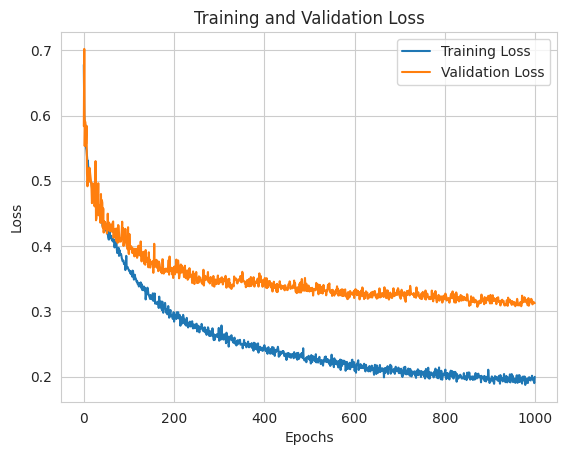

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 确保输入数据形状为 (samples, timesteps, features)
# 如果尚未调整形状，可以通过以下代码进行：
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 假设 features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 定义 CNN 模型
model = Sequential([
    # 第一层卷积层
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),  # 最大池化层
    Dropout(0.2),  # 防止过拟合

    # 第二层卷积层
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # 展平和全连接层
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),

    # 输出层
    Dense(1)  # 输出一个值用于回归
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 查看模型结构
model.summary()

# 训练模型
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)

# 预测并评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算评价指标
def evaluate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    return mse, rmse, mae, r2

# 输出训练集和测试集的评价指标
train_metrics = evaluate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = evaluate_metrics(y_test, y_test_pred, "Test Set")


# 可视化训练过程
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 197, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 98, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)               

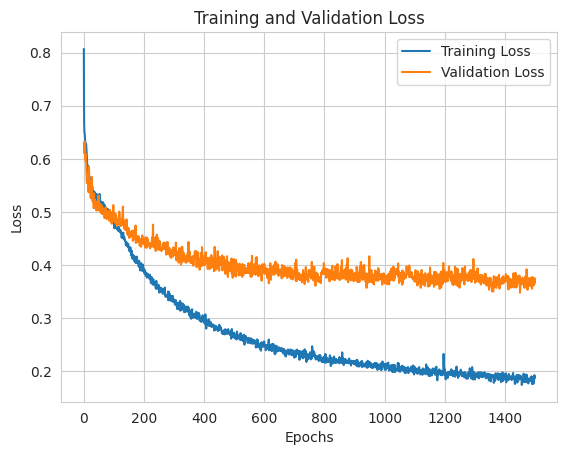

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 确保输入数据形状为 (samples, timesteps, features)
# 如果尚未调整形状，可以通过以下代码进行：
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 假设 features = 1
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 定义 CNN + LSTM 模型
model = Sequential([
    # CNN 部分
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # LSTM 部分
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),

    # Dense 全连接部分
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # 输出一个值用于回归
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 查看模型结构
model.summary()

# 训练模型
history = model.fit(X_train, y_train, epochs=1500, batch_size=32, validation_split=0.2, verbose=1)

# 预测并评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")



from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算评价指标
def evaluate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    return mse, rmse, mae, r2

# 输出训练集和测试集的评价指标
train_metrics = evaluate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = evaluate_metrics(y_test, y_test_pred, "Test Set")


# 可视化训练过程
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 199, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 197, 64)      256         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 98, 64)       0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 98, 64)       0           max_pooling1d_6[0][0]            
____________________________________________________________________________________________

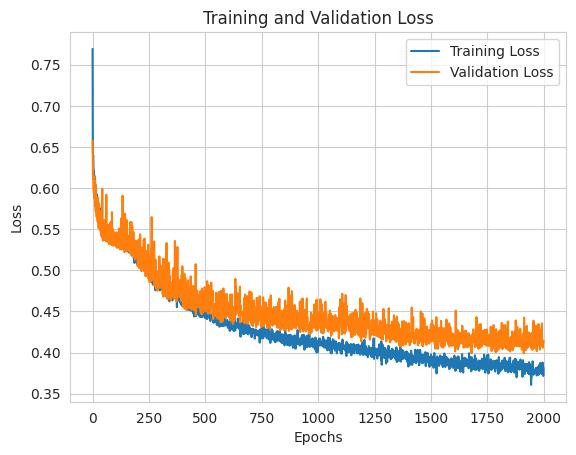

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, Input, Multiply, Permute, Lambda, Activation, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Attention 机制
def attention_layer(inputs):
    # inputs shape: (batch_size, time_steps, features)
    attention_scores = Dense(1, activation='tanh')(inputs)  # 计算注意力分数
    attention_scores = tf.squeeze(attention_scores, axis=-1)  # 删除最后一个维度
    attention_weights = Activation('softmax')(attention_scores)  # 应用 softmax 获得权重
    attention_weights = tf.expand_dims(attention_weights, axis=-1)  # 恢复维度
    attention_output = Multiply()([inputs, attention_weights])  # 权重应用到输入上
    return tf.reduce_sum(attention_output, axis=1)  # 对时间步求和

# 定义模型
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN 部分
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)

cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_layer)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Dropout(0.2)(cnn_layer)

# Attention 部分
attention_output = attention_layer(cnn_layer)

# 全连接部分
dense_layer = Dense(64, activation='relu')(attention_output)
dense_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1)(dense_layer)  # 输出一个值用于回归

# 定义完整模型
model = Model(inputs=input_layer, outputs=output_layer)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 查看模型结构
model.summary()

# 训练模型
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2, verbose=1)

# 预测并评估模型
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 计算评价指标
def evaluate_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    return mse, rmse, mae, r2

# 输出训练集和测试集的评价指标
train_metrics = evaluate_metrics(y_train, y_train_pred, "Training Set")
test_metrics = evaluate_metrics(y_test, y_test_pred, "Test Set")


# 可视化训练过程
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 197, 64)           256       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 98, 64)            0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 98, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 48, 32)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)             

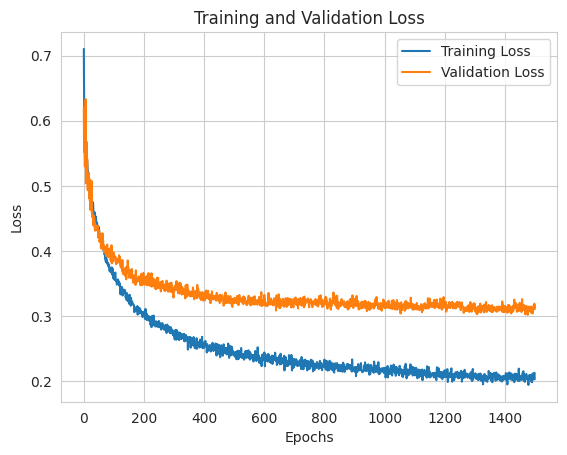

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import math
# 模拟数据
torch.manual_seed(42)
np.random.seed(42)
# X = np.random.rand(300, 199)  # 300条数据，每条199个特征
# y = np.random.rand(300)       # 每条数据对应一个目标值
# protein_list = np.array([f"Protein_{i}" for i in range(300)])  # 关联序列（可选）

# 数据拆分
# X_train, X_test, y_train, y_test, sequence_train, sequence_test = train_test_split(
#     X, y, protein_list, test_size=0.2, random_state=21
# )

# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) # 转换为二维张量.unsqueeze(-1) 
y_test = torch.tensor(y_test, dtype=torch.float32)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # 加上位置编码
        return x


class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, hidden_mlp):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding层
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, activation="gelu"),
            num_layers=num_layers
        )
        self.norm = nn.LayerNorm(d_model)  # LayerNorm增加稳定性
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, hidden_mlp),  # 增加隐藏层
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_mlp, hidden_mlp // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_mlp // 2, 1)  # 最终输出层
        )

    def forward(self, x):
        # 输入形状: (batch_size, input_dim)
        x = self.embedding(x)  # Embedding (batch_size, input_dim) -> (batch_size, d_model)
        x = x.unsqueeze(1)  # 添加序列维度 (batch_size, d_model) -> (batch_size, 1, d_model)
        x = self.pos_encoder(x)  # 添加位置编码
        x = x.permute(1, 0, 2)  # 调整为 (seq_len, batch_size, d_model)
        x = self.transformer(x)  # Transformer 编码
        x = self.norm(x.mean(dim=0))  # 在序列维度取平均后归一化 (batch_size, d_model)
        output = self.fc_out(x)  # 输出层 (batch_size, d_model) -> (batch_size, 1)
        return output


# 初始化模型、损失函数和优化器
model = TransformerRegressor(input_dim=199, d_model=1024, nhead=8, num_layers=6,dropout=0.2,hidden_mlp=256)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.05)
# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = loss_fn(predictions, y_train)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# 评估函数
def evaluate_model(model, X, y, dataset_name="Dataset"):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        y_true = y.detach().numpy()
        # print(y_pred)
        # print(y_true)

        mse = mean_squared_error(y_true, y_pred.detach().numpy())
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"\n=== {dataset_name} Metrics ===")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        return mse, rmse, mae, r2

# 评估训练集和测试集
train_metrics = evaluate_model(model, X_train, y_train, dataset_name="Training Set")
test_metrics = evaluate_model(model, X_test, y_test, dataset_name="Test Set")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 197, 64)           256       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 98, 64)            0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 98, 64)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 48, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)               

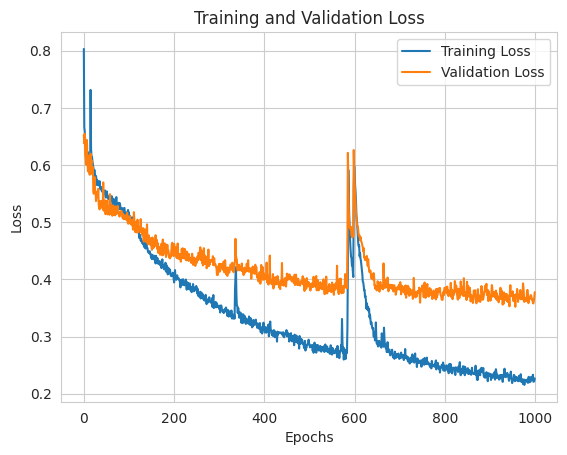

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 模拟数据
# np.random.seed(21)
# torch.manual_seed(21)
# X = np.random.rand(300, 10, 5)  # 输入形状 (样本数, 时间步, 特征数)
# y = np.random.rand(300)         # 输出形状 (样本数, )
# 
# # 数据划分
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# 转换为 PyTorch 张量
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)  # 转为二维张量
# y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# 定义 LSTM 回归模型
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM 前向传播
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim)
        last_hidden = lstm_out  # 取最后一个时间步的隐藏状态
        output = self.fc(last_hidden)    # 输出层
        return output

# 模型参数
input_dim = 199      # 输入特征数
hidden_dim = 256    # LSTM 隐藏层维度
num_layers = 2     # LSTM 层数
output_dim = 1     # 输出维度

# 初始化模型、损失函数和优化器
model = LSTMRegressor(input_dim, hidden_dim, num_layers, output_dim)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)  # 前向传播
    loss = loss_fn(y_pred, y_train)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# 模型评估函数
def evaluate_model(model, X, y, dataset_name="Dataset"):
    model.eval()
    with torch.no_grad():
        y_pred = model(X).detach().numpy()  # 转为 NumPy 格式
        y_true = y.squeeze().numpy()

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"\n=== {dataset_name} Metrics ===")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared (R²): {r2:.4f}")
        return mse, rmse, mae, r2

# 评估训练集和测试集
train_metrics = evaluate_model(model, X_train, y_train, dataset_name="Training Set")
test_metrics = evaluate_model(model, X_test, y_test, dataset_name="Test Set")


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 199, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 197, 64)      256         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_24 (MaxPooling1D) (None, 98, 64)       0           conv1d_24[0][0]                  
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 98, 64)       0           max_pooling1d_24[0][0]           
____________________________________________________________________________________________

In [12]:
y_test

tensor([[0.9031],
        [2.0000],
        [0.1728],
        ...,
        [2.0751],
        [1.2041],
        [2.5667]])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


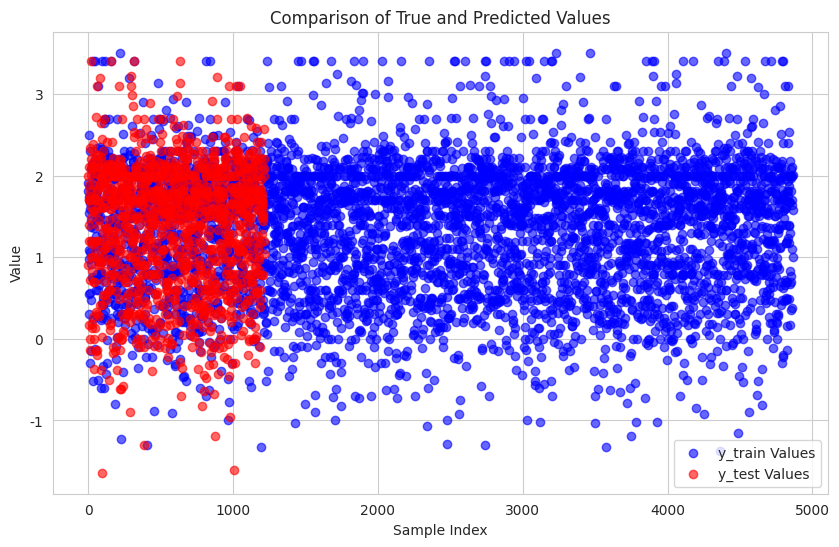

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_train)), y_train, label='y_train Values', color='blue', alpha=0.6)
plt.scatter(range(len(y_test)), y_test, label='y_test Values', color='red', alpha=0.6)
plt.title('Comparison of True and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from kan import  *
# initialize KAN with G=3
model = KAN(width=[199,7,1], grid=30, k=5,seed=2)
# model(dataset['train_input'])
# model.plot(beta=100)

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                            | 0/5 [00:00<?, ?it/s]/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error (MSE): 0.4083
Root Mean Squared Error (RMSE): 0.6390
Mean Absolute Error (MAE): 0.5083
R-squared (R2): 0.3411
Mean Absolute Percentage Error (MAPE): inf%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


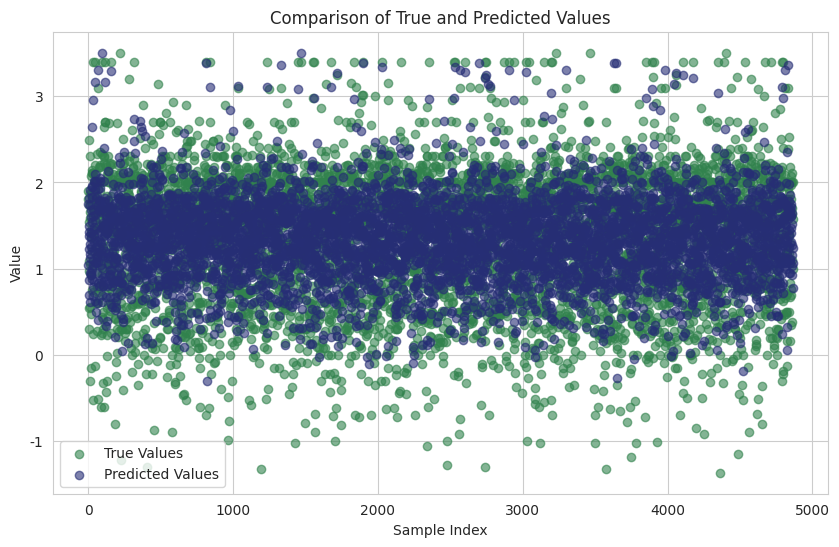

============================================================(test)
Mean Squared Error (MSE): 0.4321
Root Mean Squared Error (RMSE): 0.6573
Mean Absolute Error (MAE): 0.5223
R-squared (R2): 0.2928
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


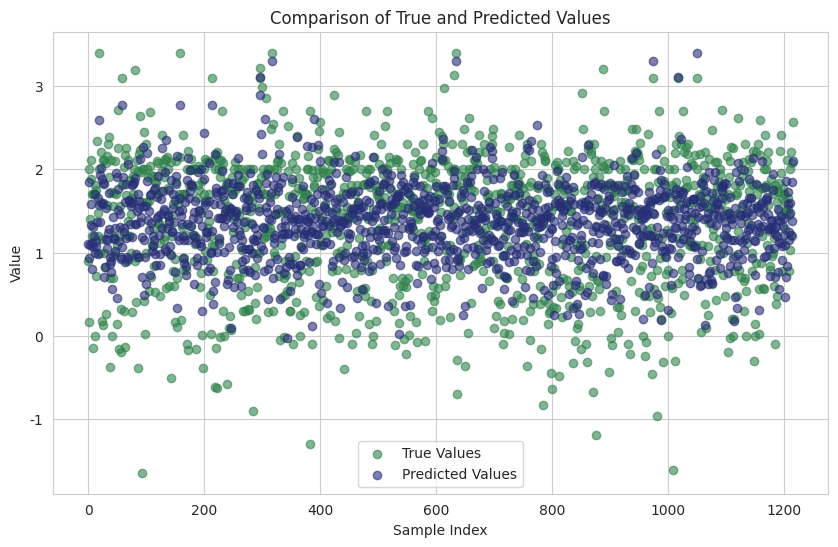

| train_loss: 6.39e-01 | test_loss: 6.57e-01 | reg: 0.00e+00 | :  20%|▏| 1/5 [04:56<19:45, 296.26s/i/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error (MSE): 0.3223
Root Mean Squared Error (RMSE): 0.5677
Mean Absolute Error (MAE): 0.4485
R-squared (R2): 0.4800
Mean Absolute Percentage Error (MAPE): inf%


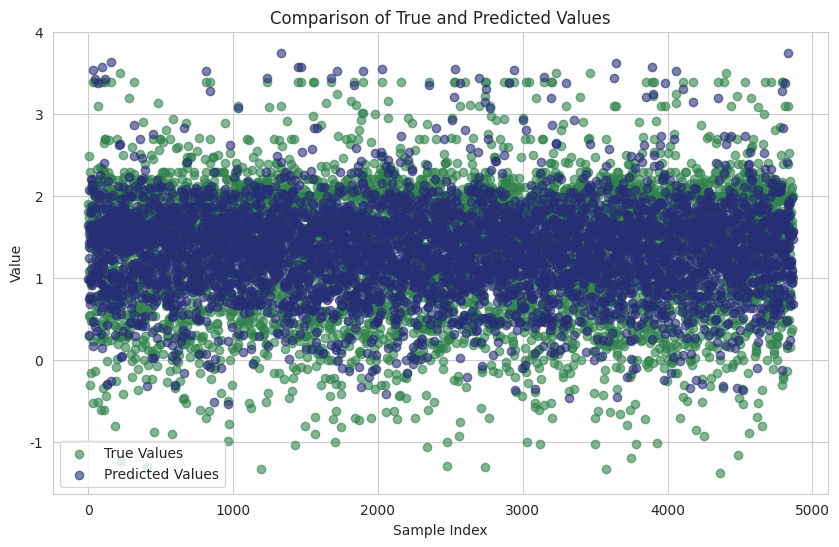

============================================================(test)
Mean Squared Error (MSE): 0.3918
Root Mean Squared Error (RMSE): 0.6259
Mean Absolute Error (MAE): 0.4855
R-squared (R2): 0.3587
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


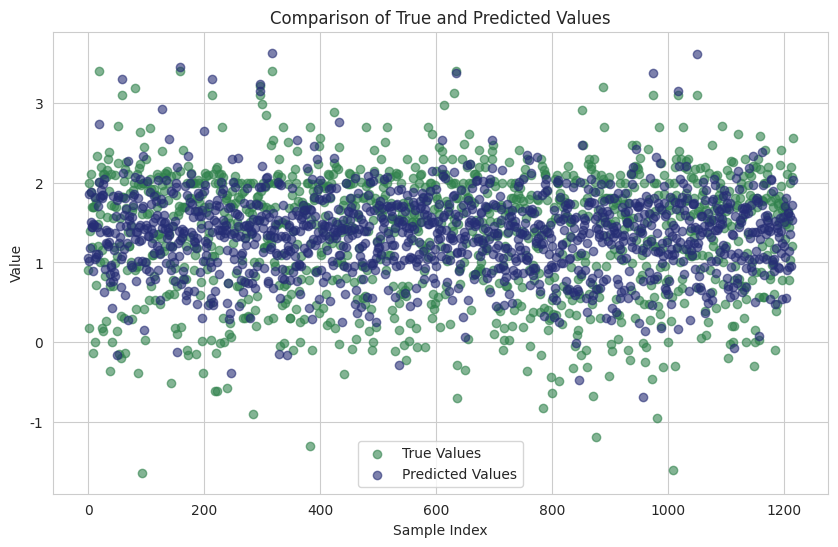

| train_loss: 5.68e-01 | test_loss: 6.26e-01 | reg: 0.00e+00 | :  40%|▍| 2/5 [08:39<12:40, 253.48s/i/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error (MSE): 0.2780
Root Mean Squared Error (RMSE): 0.5273
Mean Absolute Error (MAE): 0.4125
R-squared (R2): 0.5514
Mean Absolute Percentage Error (MAPE): inf%


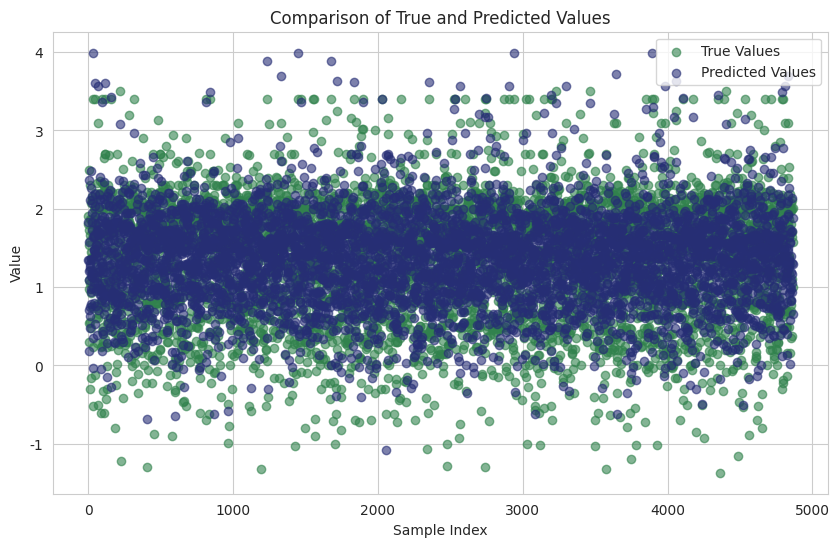

============================================================(test)
Mean Squared Error (MSE): 0.3745
Root Mean Squared Error (RMSE): 0.6120
Mean Absolute Error (MAE): 0.4750
R-squared (R2): 0.3870
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


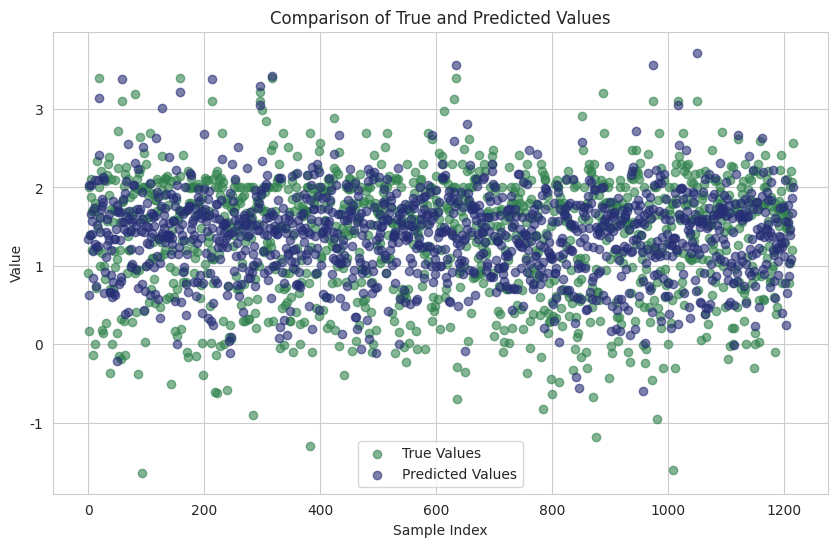

| train_loss: 5.27e-01 | test_loss: 6.12e-01 | reg: 0.00e+00 | :  60%|▌| 3/5 [12:25<08:01, 240.68s/i/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error (MSE): 0.2422
Root Mean Squared Error (RMSE): 0.4921
Mean Absolute Error (MAE): 0.3847
R-squared (R2): 0.6093
Mean Absolute Percentage Error (MAPE): inf%


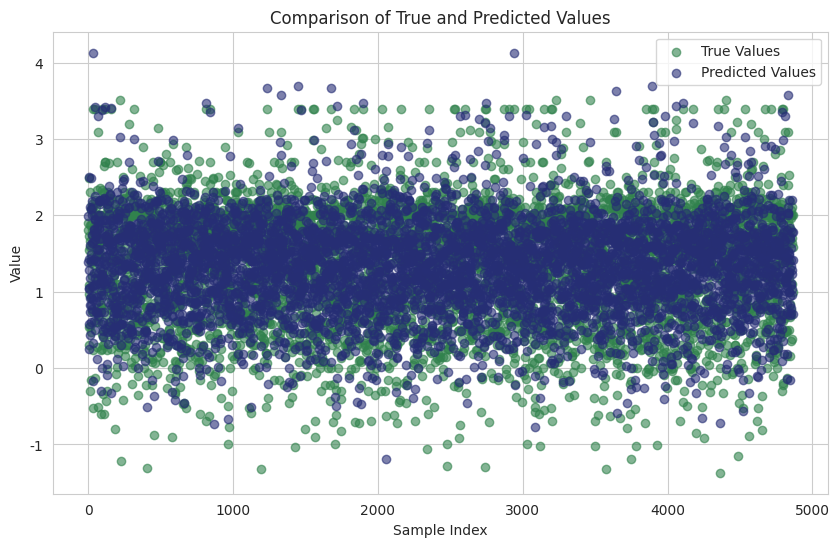

============================================================(test)
Mean Squared Error (MSE): 0.3689
Root Mean Squared Error (RMSE): 0.6074
Mean Absolute Error (MAE): 0.4664
R-squared (R2): 0.3962
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


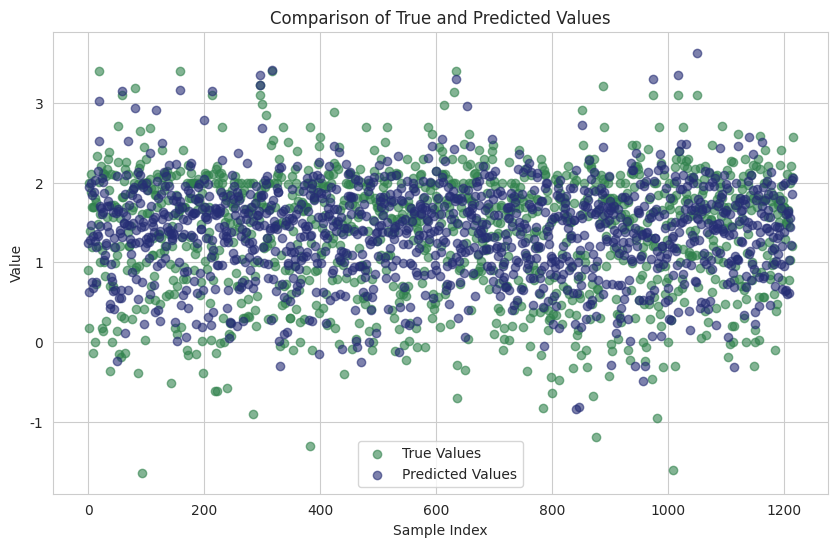

| train_loss: 4.92e-01 | test_loss: 6.07e-01 | reg: 0.00e+00 | :  80%|▊| 4/5 [16:12<03:55, 235.27s/i

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_acts

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


Mean Squared Error (MSE): 0.2141
Root Mean Squared Error (RMSE): 0.4627
Mean Absolute Error (MAE): 0.3601
R-squared (R2): 0.6545
Mean Absolute Percentage Error (MAPE): inf%


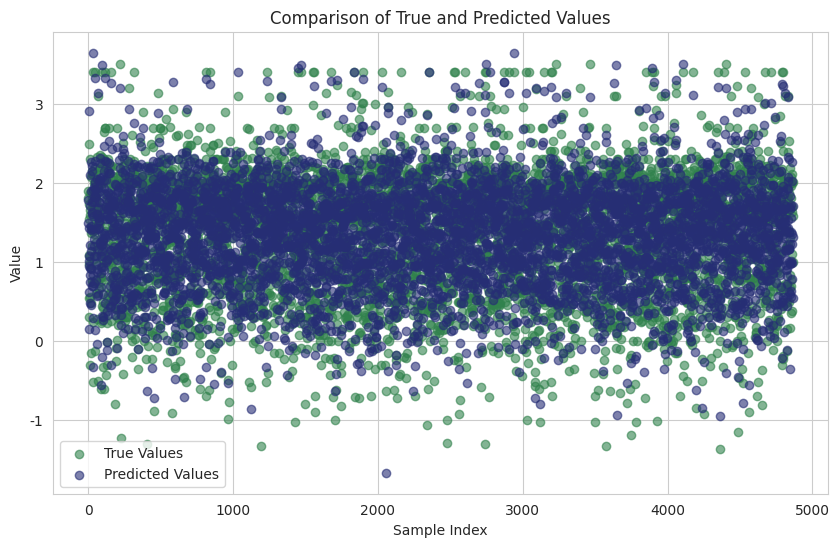

============================================================(test)
Mean Squared Error (MSE): 0.3634
Root Mean Squared Error (RMSE): 0.6029
Mean Absolute Error (MAE): 0.4602
R-squared (R2): 0.4051
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


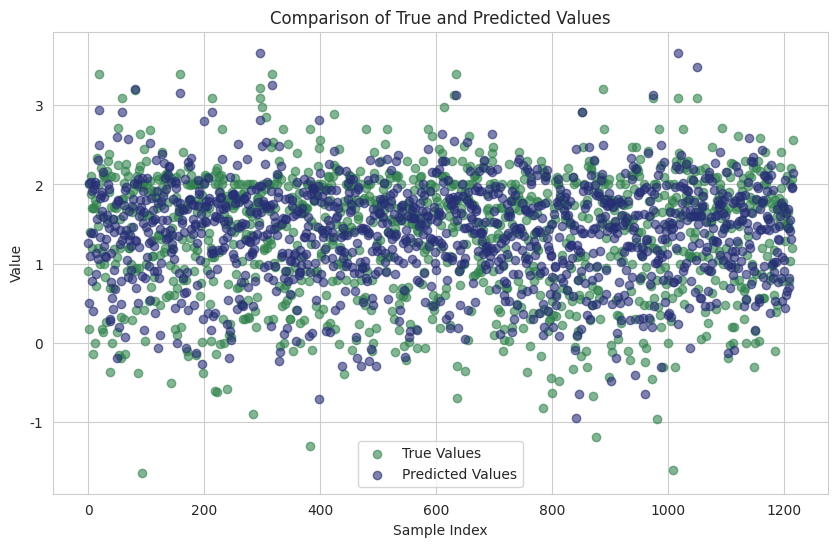

| train_loss: 4.63e-01 | test_loss: 6.03e-01 | reg: 6.38e+01 | : 100%|█| 5/5 [24:42<00:00, 296.47s/i

saving model version 0.1


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from itertools import count
def train_mse():
    count_train = count(start=1, step=1) 
    from sklearn import metrics
    train_pred=model(X_train)
    # print(train_pred)
    # print(y_train)
    # y_train=y_train.detach().numpy()
    train_pred=train_pred.detach().numpy()
    
    mse = metrics.mean_squared_error(y_train.detach().numpy(), train_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_train.detach().numpy(), train_pred)
    r2 = metrics.r2_score(y_train.detach().numpy(), train_pred)
    def mean_absolute_percentage_error(y_true, y_pred):    
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = mean_absolute_percentage_error(y_train.detach().numpy(), train_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_train)), y_train, label='True Values', color='#31824d', alpha=0.6)
    plt.scatter(range(len(train_pred)), train_pred, label='Predicted Values', color='#262e75', alpha=0.6)
    plt.title('Comparison of True and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    count_train=next(count_train)
    plt.savefig(str((count_train))+'_train_reg.png',dpi=300)
    plt.show()
    
    return mse
def test_mse():
    count_test = count(start=1, step=1) 
    from sklearn import metrics
    test_pred=model(X_test)
    # y_test=y_test.detach().numpy()
    test_pred=test_pred.detach().numpy()
    
    mse = metrics.mean_squared_error(y_test.detach().numpy(), test_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(y_test.detach().numpy(), test_pred)
    r2 = metrics.r2_score(y_test.detach().numpy(), test_pred)
    def mean_absolute_percentage_error(y_true, y_pred):    
        return np.mean(np.abs((y_true- y_pred) / y_true)) * 100
    print('============================================================(test)')
    mape = mean_absolute_percentage_error(y_test.detach().numpy(), test_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='True Values', color='#31824d', alpha=0.6)
    plt.scatter(range(len(test_pred)), test_pred, label='Predicted Values', color='#262e75', alpha=0.6)
    plt.title('Comparison of True and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    count_test=next(count_test)
    plt.savefig(str((count_test))+'_test_reg.png',dpi=300)
    plt.show()
    return mse
# model.fit(dataset, opt="LBFGS", steps=20,metrics=(train_acc,test_acc)) lamb=0.0, lamb_entropy=2.,loss_fn=torch.nn.MSELoss(), 
image_folder = 'video_img'
results = model.fit(dataset, opt="LBFGS", metrics=(train_mse, test_mse), steps=5, save_fig=False, img_folder=image_folder)

In [24]:
model.feature_score

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


tensor([4.2506e-01, 3.7837e-01, 2.9188e-01, 2.4462e-01, 2.9063e-01, 3.5337e-01,
        5.1611e-01, 2.7053e-01, 4.7702e-01, 5.4158e-01, 3.9003e-01, 3.4713e-01,
        3.7752e-01, 4.2612e-01, 3.5088e-01, 3.6265e-01, 2.7707e-01, 4.1716e-01,
        4.0145e-01, 2.0610e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4503e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7603e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.8078e-01, 1.4936e-

In [25]:
import torch

# 假设 model.feature_score 是一个 Tensor
feature_scores = model.feature_score  # Tensor

# 前 20 个数据中的 top 5
top5_values_1, top5_indices_1 = torch.topk(feature_scores[:20], 5)
print("Top 5 feature scores in first 20:", top5_values_1)
print("Indices of top 5 feature scores in first 20:", top5_indices_1)

# 中间 20-187 的数据中的 top 5
top5_values_2, top5_indices_2 = torch.topk(feature_scores[20:187], 5)
top5_indices_2 += 20  # 调整索引，使其与原始数据的索引对齐
print("Top 5 feature scores in indices 20-187:", top5_values_2)
print("Indices of top 5 feature scores in indices 20-187:", top5_indices_2)

# 最后 12 个数据中的 top 5
top5_values_3, top5_indices_3 = torch.topk(feature_scores[187:], 5)
top5_indices_3 += 187  # 调整索引，使其与原始数据的索引对齐
print("Top 5 feature scores in indices 187 and beyond:", top5_values_3)
print("Indices of top 5 feature scores in indices 187 and beyond:", top5_indices_3)


l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
Top 5 feature scores in first 20: tensor([0.5416, 0.5161, 0.4770, 0.4261, 0.4251])
Indices of top 5 feature scores in first 20: tensor([ 9,  6,  8, 13,  0])
Top 5 feature scores in indices 20-187: tensor([0.3050, 0.3049, 0.2959, 0.2925, 0.2747])
Indices of top 5 feature scores in indices 20-187: tensor([113, 147, 128, 129, 170])
Top 5 feature scores in indices 187 and beyond: tensor([0.5744, 0.4398, 0.4267, 0.3486, 0.2638])
Indices of top 5 feature scores in indices 187 and beyond: tensor([190, 198, 194, 195, 191])


In [ ]:
# Top 5 feature scores in first 20: tensor([0.5799, 0.5202, 0.4796, 0.4338, 0.4300])
# Indices of top 5 feature scores in first 20: tensor([ 9,  6,  8,  0, 13])
# Top 5 feature scores in indices 20-187: tensor([0.3075, 0.3071, 0.3053, 0.2907, 0.2823])
# Indices of top 5 feature scores in indices 20-187: tensor([147, 113, 128, 129, 106])
# Top 5 feature scores in indices 187 and beyond: tensor([0.5841, 0.4475, 0.4274, 0.3525, 0.2649])
# Indices of top 5 feature scores in indices 187 and beyond: tensor([190, 198, 194, 195, 191])

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


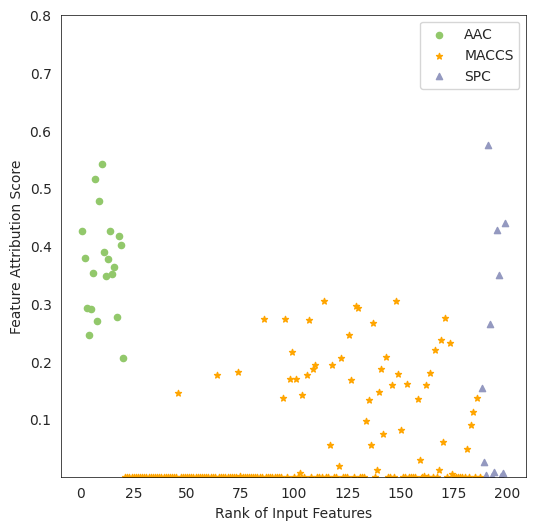

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

n_var = 199
feature_scores = model.feature_score.cpu().detach().numpy()
x_values = np.arange(n_var) + 1

# 前20个
plt.figure(figsize=(6, 6))
plt.grid(False)
plt.scatter(x_values[:20], feature_scores[:20], color='#92c86b', label='AAC',s=20)
# 中间167个
plt.scatter(x_values[20:187], feature_scores[20:187], color='orange', label='MACCS',s=20, marker='*')
# 最后12个
plt.scatter(x_values[187:], feature_scores[187:], color='#9499c0', marker='^', label='SPC', s=20)
# 设置坐标轴为对数刻度
ax = plt.gca()  # 获取当前坐标轴
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# 添加标签和图例
plt.xlabel('Rank of Input Features')
plt.ylabel('Feature Attribution Score')
plt.legend()
plt.ylim(0.0001, 0.8)
plt.savefig('fe1_reg.png',dpi=300)
# 显示图表 , fontsize=12
plt.show()




findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


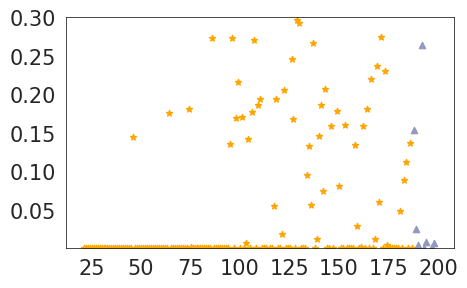

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

n_var = 199
feature_scores = model.feature_score.cpu().detach().numpy()
x_values = np.arange(n_var) + 1

# 前20个
plt.figure(figsize=(5, 3))
plt.grid(False)
# plt.scatter(x_values[:20], feature_scores[:20], color='#92c86b', label='AAC',s=20)
# 中间167个
# 中间167个
plt.scatter(x_values[20:187], feature_scores[20:187], color='orange', label='MACCS',s=20, marker='*')
# 最后12个
plt.scatter(x_values[187:], feature_scores[187:], color='#9499c0', marker='^', label='SPC', s=20)
# 设置坐标轴为对数刻度
ax = plt.gca()  # 获取当前坐标轴
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)
# 添加标签和图例
# plt.xlabel('Rank of Input Features')
# plt.ylabel('Feature Attribution Score')
# plt.legend()
plt.ylim(0.0001, 0.3)
plt.xticks(fontsize=15)  # x 轴刻度字体大小
plt.yticks(fontsize=15)  #
plt.savefig('fe2_reg.png',dpi=300)
# 显示图表 , fontsize=12
plt.show()




In [28]:
lib = ['x','x^2','x^3','x^4','x^5','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

fixing (0,0,0) with x, r2=0.7230467200279236, c=1
fixing (0,0,1) with x, r2=0.015468568541109562, c=1
fixing (0,0,2) with x, r2=0.6441943049430847, c=1
fixing (0,0,3) with x, r2=0.8762906789779663, c=1
fixing (0,0,4) with x, r2=0.42708951234817505, c=1
fixing (0,0,5) with x, r2=0.7542232871055603, c=1
fixing (0,0,6) with x, r2=0.6695334911346436, c=1
fixing (0,1,0) with x, r2=0.2145712822675705, c=1
fixing (0,1,1) with x, r2=0.983855128288269, c=1
fixing (0,1,2) with x, r2=0.49677082896232605, c=1
fixing (0,1,3) with x, r2=0.516029417514801, c=1
fixing (0,1,4) with x, r2=0.6454612016677856, c=1
fixing (0,1,5) with x, r2=0.9261614680290222, c=1
fixing (0,1,6) with x, r2=0.7007092237472534, c=1
fixing (0,2,0) with sin, r2=0.9554468393325806, c=2
fixing (0,2,1) with sin, r2=0.9981987476348877, c=2
fixing (0,2,2) with x, r2=0.8985044360160828, c=1
fixing (0,2,3) with sqrt, r2=0.9984066486358643, c=2
fixing (0,2,4) with x, r2=0.5646111965179443, c=1
fixing (0,2,5) with x, r2=0.8941094279289

In [29]:
torch.save(model.state_dict(), 'Re_model_weights_KAN.pth')

In [30]:
formula

0.0302980013897416*x_1 + 0.0254433375909526*x_10 - 0.0515946579951039*x_101 - 0.00137380933624422*x_103 + 0.00522798842020738*x_104 - 0.000251719951919769*x_105 - 0.0499442464151755*x_106 - 0.101868424411701*x_107 + 0.015857643689595*x_109 + 0.0845932456923669*x_11 + 0.0126195336557281*x_110 + 0.0042888328770275*x_112 - 0.00593865840804592*x_114 + 0.0023656125118316*x_117 - 0.0172297038765083*x_118 + 0.0657028758508689*x_12 - 0.00624789735962611*x_121 + 0.00142832993382414*x_122 - 0.0158821047085802*x_126 + 0.0145520954057906*x_127 + 0.000281208220660778*x_129 + 0.046890876657595*x_13 - 0.0100638141010406*x_130 + 0.0074483397636627*x_134 - 0.0129806868074579*x_135 + 0.0167316849129122*x_136 - 0.0713810000890365*x_137 - 0.0023299907524359*x_139 + 0.0288074764214805*x_14 + 0.009972038672968*x_140 - 0.0450978564457204*x_141 + 0.0264905203083375*x_142 - 0.0502465203597836*x_143 - 0.0184801462459436*x_146 - 0.0414519171537304*x_148 - 0.0298002998762442*x_149 - 0.0556425250484502*x_15 + 0.01

In [ ]:
# model.save_ckpt("KAN_reg","/tmp/pycharm_project_763/result")
# model=KAN.load_ckpt("KAN_reg","/tmp/pycharm_project_763/result")

In [ ]:
# Top 5 feature scores in first 20: tensor([0.5416, 0.5161, 0.4770, 0.4261, 0.4251])
# Indices of top 5 feature scores in first 20: tensor([ 9,  6,  8, 13,  0])
# Top 5 feature scores in indices 20-187: tensor([0.3050, 0.3049, 0.2959, 0.2925, 0.2747])
# Indices of top 5 feature scores in indices 20-187: tensor([113, 147, 128, 129, 170])
# Top 5 feature scores in indices 187 and beyond: tensor([0.5744, 0.4398, 0.4267, 0.3486, 0.2638])
# Indices of top 5 feature scores in indices 187 and beyond: tensor([190, 198, 194, 195, 191])

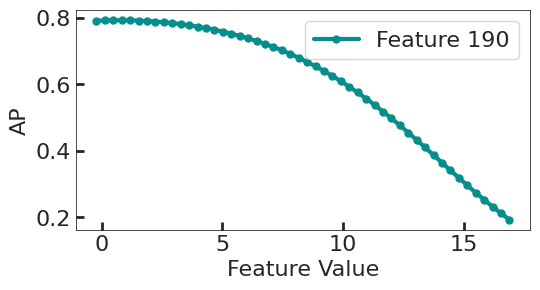

In [50]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        # predict = float(formula.subs(subs_dict))
        from scipy.special import expit  # expit 是 Sigmoid 函数

        predict = float(formula.subs(subs_dict))  # 将符号表达式转换为浮点数
        predict = expit(predict)  # 应用 expit 函数，转换为概率  # 使
        
        
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp_14 = 190  # 假设选择第一个特征进行 PDP
feature_index_pdp_9 = 198 
feature_index_pdp_8 = 194
feature_index_pdp_3 = 195 
feature_index_pdp_11 = 170

feature_values_pdp_14 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_14]), max(dataset['test_input'][:, feature_index_pdp_14]), num=50)
feature_values_pdp_9 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_9]), max(dataset['test_input'][:, feature_index_pdp_9]), num=50)
feature_values_pdp_8 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_8]), max(dataset['test_input'][:, feature_index_pdp_8]), num=50)
feature_values_pdp_3 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_3]), max(dataset['test_input'][:, feature_index_pdp_3]), num=50)
feature_values_pdp_11 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_11]), max(dataset['test_input'][:, feature_index_pdp_11]), num=50)


# 计算部分依赖
predictions_pdp_14 = partial_dependence(feature_index_pdp_14, feature_values_pdp_14, formula, dataset)
# predictions_pdp_9 = partial_dependence(feature_index_pdp_9, feature_values_pdp_9, formula, dataset)
# predictions_pdp_8 = partial_dependence(feature_index_pdp_8, feature_values_pdp_8, formula, dataset)
# predictions_pdp_3 = partial_dependence(feature_index_pdp_3, feature_values_pdp_3, formula, dataset)
# predictions_pdp_11 = partial_dependence(feature_index_pdp_11, feature_values_pdp_11, formula, dataset)

# 绘制部分依赖图（PDP）# 设置Seaborn样式
# sns.set(style="whitegrid")
plt.figure(figsize=(5.5, 3))
plt.grid(False)
ax = plt.gca()  # 获取当前坐标轴
# border_width = 4  # 边框粗细大小
ax.set_xlabel('Feature Value', fontsize=16)
ax.set_ylabel('AP', fontsize=16)
# ax.spines['top'].set_linewidth(border_width)
# ax.spines['bottom'].set_linewidth(border_width)
# ax.spines['left'].set_linewidth(border_width)
# ax.spines['right'].set_linewidth(border_width)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)
plt.plot(feature_values_pdp_14, predictions_pdp_14,  linestyle='-', marker='o',color='#068e8d', linewidth=3, markersize=5, label='Feature 190')
# plt.fill_between(feature_values_pdp_14, predictions_pdp_14, color='#a51c36', alpha=0.1)
# marker='o',marker='*',marker='^',
# plt.plot(feature_values_pdp_9, predictions_pdp_9,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 9')
# plt.fill_between(feature_values_pdp_9, predictions_pdp_9, color='#682487', alpha=0.1)

# plt.plot(feature_values_pdp_8, predictions_pdp_8,  linestyle='-',marker='o', color='#4485c7', linewidth=3, markersize=4, label='Feature 8')
# plt.fill_between(feature_values_pdp_8, predictions_pdp_8, color='#4485c7', alpha=0.1)

# plt.plot(feature_values_pdp_3, predictions_pdp_3,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 3')
# plt.fill_between(feature_values_pdp_3, predictions_pdp_3, color='#682487', alpha=0.1)
# 
# plt.plot(feature_values_pdp_11, predictions_pdp_11,  linestyle='-', marker='o',color='#4485c7', linewidth=3, markersize=4, label='Feature 11')
# plt.fill_between(feature_values_pdp_11, predictions_pdp_11, color='#4485c7', alpha=0.1)

   # 添加标题和轴标签，并设置字体大小
# plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.tick_params(direction='in', length=6, width=2, labelsize=16)  # 设置刻度线方向、长度和宽度
plt.tick_params(which='both')  # 显示主刻度和次刻度线
plt.tick_params(axis='both', which='both', bottom=True, left=True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
# sns.despine(left=True, bottom=True)
plt.savefig('reg_3_1.png',dpi=300)
plt.show()

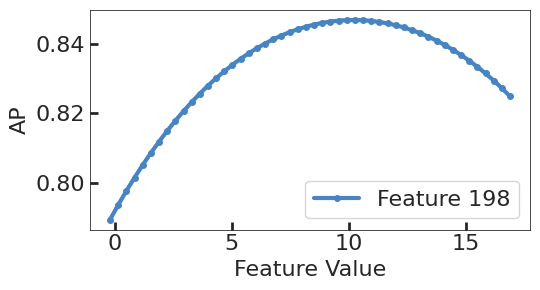

In [49]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        # predict = float(formula.subs(subs_dict))
        from scipy.special import expit  # expit 是 Sigmoid 函数

        predict = float(formula.subs(subs_dict))  # 将符号表达式转换为浮点数
        predict = expit(predict)  # 应用 expit 函数，转换为概率  # 使
        
        
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp_14 = 113  # 假设选择第一个特征进行 PDP
feature_index_pdp_9 = 198 
feature_index_pdp_8 = 128
feature_index_pdp_3 = 129 
feature_index_pdp_11 = 0

feature_values_pdp_14 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_14]), max(dataset['test_input'][:, feature_index_pdp_14]), num=50)
feature_values_pdp_9 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_9]), max(dataset['test_input'][:, feature_index_pdp_9]), num=50)
feature_values_pdp_8 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_8]), max(dataset['test_input'][:, feature_index_pdp_8]), num=50)
feature_values_pdp_3 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_3]), max(dataset['test_input'][:, feature_index_pdp_3]), num=50)
feature_values_pdp_11 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_11]), max(dataset['test_input'][:, feature_index_pdp_11]), num=50)


# 计算部分依赖
# predictions_pdp_14 = partial_dependence(feature_index_pdp_14, feature_values_pdp_14, formula, dataset)
predictions_pdp_9 = partial_dependence(feature_index_pdp_9, feature_values_pdp_9, formula, dataset)
# predictions_pdp_8 = partial_dependence(feature_index_pdp_8, feature_values_pdp_8, formula, dataset)
# predictions_pdp_3 = partial_dependence(feature_index_pdp_3, feature_values_pdp_3, formula, dataset)
# predictions_pdp_11 = partial_dependence(feature_index_pdp_11, feature_values_pdp_11, formula, dataset)

# 绘制部分依赖图（PDP）# 设置Seaborn样式
# sns.set(style="whitegrid")
plt.figure(figsize=(5.5, 3))
plt.grid(False)
ax = plt.gca()  # 获取当前坐标轴
# border_width = 4  # 边框粗细大小
ax.set_xlabel('Feature Value', fontsize=16)
ax.set_ylabel('AP', fontsize=16)
# ax.spines['top'].set_linewidth(border_width)
# ax.spines['bottom'].set_linewidth(border_width)
# ax.spines['left'].set_linewidth(border_width)
# ax.spines['right'].set_linewidth(border_width)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)
# plt.plot(feature_values_pdp_14, predictions_pdp_14,  linestyle='-', marker='o',color='#068e8d', linewidth=3, markersize=5, label='Feature 9')

# marker='o',marker='*',marker='^',
plt.plot(feature_values_pdp_9, predictions_pdp_9,  linestyle='-',marker='o', color='#4784c3', linewidth=3, markersize=4, label='Feature 198')


# plt.plot(feature_values_pdp_8, predictions_pdp_8,  linestyle='-',marker='o', color='#4485c7', linewidth=3, markersize=4, label='Feature 8')
# plt.fill_between(feature_values_pdp_8, predictions_pdp_8, color='#4485c7', alpha=0.1)

# plt.plot(feature_values_pdp_3, predictions_pdp_3,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 3')
# plt.fill_between(feature_values_pdp_3, predictions_pdp_3, color='#682487', alpha=0.1)
# 
# plt.plot(feature_values_pdp_11, predictions_pdp_11,  linestyle='-', marker='o',color='#4485c7', linewidth=3, markersize=4, label='Feature 11')
# plt.fill_between(feature_values_pdp_11, predictions_pdp_11, color='#4485c7', alpha=0.1)

   # 添加标题和轴标签，并设置字体大小
# plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.tick_params(direction='in', length=6, width=2, labelsize=16)  # 设置刻度线方向、长度和宽度
plt.tick_params(which='both')  # 显示主刻度和次刻度线
plt.tick_params(axis='both', which='both', bottom=True, left=True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
# sns.despine(left=True, bottom=True)
plt.savefig('reg_3_2.png',dpi=300)
plt.show()

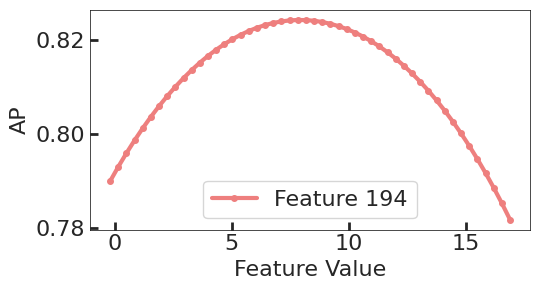

In [48]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        # predict = float(formula.subs(subs_dict))
        from scipy.special import expit  # expit 是 Sigmoid 函数

        predict = float(formula.subs(subs_dict))  # 将符号表达式转换为浮点数
        predict = expit(predict)  # 应用 expit 函数，转换为概率  # 使
        
        
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp_14 = 9  # 假设选择第一个特征进行 PDP
feature_index_pdp_9 = 6 
feature_index_pdp_8 = 194
feature_index_pdp_3 = 13 
feature_index_pdp_11 = 0

feature_values_pdp_14 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_14]), max(dataset['test_input'][:, feature_index_pdp_14]), num=50)
feature_values_pdp_9 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_9]), max(dataset['test_input'][:, feature_index_pdp_9]), num=50)
feature_values_pdp_8 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_8]), max(dataset['test_input'][:, feature_index_pdp_8]), num=50)
feature_values_pdp_3 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_3]), max(dataset['test_input'][:, feature_index_pdp_3]), num=50)
feature_values_pdp_11 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_11]), max(dataset['test_input'][:, feature_index_pdp_11]), num=50)


# 计算部分依赖
# predictions_pdp_14 = partial_dependence(feature_index_pdp_14, feature_values_pdp_14, formula, dataset)
# # predictions_pdp_9 = partial_dependence(feature_index_pdp_9, feature_values_pdp_9, formula, dataset)
predictions_pdp_8 = partial_dependence(feature_index_pdp_8, feature_values_pdp_8, formula, dataset)
# predictions_pdp_3 = partial_dependence(feature_index_pdp_3, feature_values_pdp_3, formula, dataset)
# predictions_pdp_11 = partial_dependence(feature_index_pdp_11, feature_values_pdp_11, formula, dataset)

# 绘制部分依赖图（PDP）# 设置Seaborn样式
# sns.set(style="whitegrid")
plt.figure(figsize=(5.5, 3))
plt.grid(False)
ax = plt.gca()  # 获取当前坐标轴
# border_width = 4  # 边框粗细大小
ax.set_xlabel('Feature Value', fontsize=16)
ax.set_ylabel('AP', fontsize=16)
# ax.spines['top'].set_linewidth(border_width)
# ax.spines['bottom'].set_linewidth(border_width)
# ax.spines['left'].set_linewidth(border_width)
# ax.spines['right'].set_linewidth(border_width)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)
# plt.plot(feature_values_pdp_14, predictions_pdp_14,  linestyle='-', marker='o',color='#068e8d', linewidth=3, markersize=5, label='Feature 9')
# plt.fill_between(feature_values_pdp_14, predictions_pdp_14, color='#a51c36', alpha=0.1)
# marker='o',marker='*',marker='^',
# plt.plot(feature_values_pdp_9, predictions_pdp_9,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 9')
# plt.fill_between(feature_values_pdp_9, predictions_pdp_9, color='#682487', alpha=0.1)

plt.plot(feature_values_pdp_8, predictions_pdp_8,  linestyle='-',marker='o', color='#ee7f7e', linewidth=3, markersize=4, label='Feature 194')
# plt.fill_between(feature_values_pdp_8, predictions_pdp_8, color='#4485c7', alpha=0.1)

# plt.plot(feature_values_pdp_3, predictions_pdp_3,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 3')
# plt.fill_between(feature_values_pdp_3, predictions_pdp_3, color='#682487', alpha=0.1)
# 
# plt.plot(feature_values_pdp_11, predictions_pdp_11,  linestyle='-', marker='o',color='#4485c7', linewidth=3, markersize=4, label='Feature 11')
# plt.fill_between(feature_values_pdp_11, predictions_pdp_11, color='#4485c7', alpha=0.1)

   # 添加标题和轴标签，并设置字体大小
# plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.tick_params(direction='in', length=6, width=2, labelsize=16)  # 设置刻度线方向、长度和宽度
plt.tick_params(which='both')  # 显示主刻度和次刻度线
plt.tick_params(axis='both', which='both', bottom=True, left=True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
# sns.despine(left=True, bottom=True)
plt.savefig('reg_3_3.png',dpi=300)
plt.show()

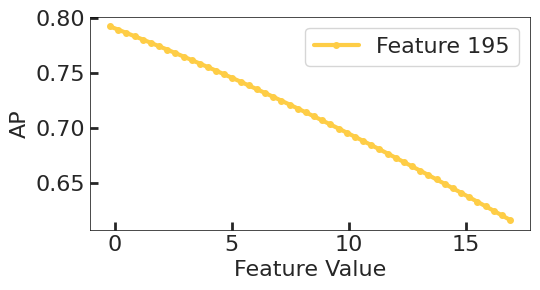

In [47]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        # predict = float(formula.subs(subs_dict))
        from scipy.special import expit  # expit 是 Sigmoid 函数

        predict = float(formula.subs(subs_dict))  # 将符号表达式转换为浮点数
        predict = expit(predict)  # 应用 expit 函数，转换为概率  # 使
        
        
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp_14 = 9  # 假设选择第一个特征进行 PDP
feature_index_pdp_9 = 6 
feature_index_pdp_8 = 8
feature_index_pdp_3 = 195 
feature_index_pdp_11 = 0

feature_values_pdp_14 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_14]), max(dataset['test_input'][:, feature_index_pdp_14]), num=50)
feature_values_pdp_9 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_9]), max(dataset['test_input'][:, feature_index_pdp_9]), num=50)
feature_values_pdp_8 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_8]), max(dataset['test_input'][:, feature_index_pdp_8]), num=50)
feature_values_pdp_3 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_3]), max(dataset['test_input'][:, feature_index_pdp_3]), num=50)
feature_values_pdp_11 = np.linspace(min(dataset['test_input'][:, feature_index_pdp_11]), max(dataset['test_input'][:, feature_index_pdp_11]), num=50)


# 计算部分依赖
# predictions_pdp_14 = partial_dependence(feature_index_pdp_14, feature_values_pdp_14, formula, dataset)
# predictions_pdp_9 = partial_dependence(feature_index_pdp_9, feature_values_pdp_9, formula, dataset)
# predictions_pdp_8 = partial_dependence(feature_index_pdp_8, feature_values_pdp_8, formula, dataset)
predictions_pdp_3 = partial_dependence(feature_index_pdp_3, feature_values_pdp_3, formula, dataset)
# predictions_pdp_11 = partial_dependence(feature_index_pdp_11, feature_values_pdp_11, formula, dataset)

# 绘制部分依赖图（PDP）# 设置Seaborn样式
# sns.set(style="whitegrid")
plt.figure(figsize=(5.5, 3))
plt.grid(False)
ax = plt.gca()  # 获取当前坐标轴
# border_width = 4  # 边框粗细大小
ax.set_xlabel('Feature Value', fontsize=16)
ax.set_ylabel('AP', fontsize=16)
# ax.spines['top'].set_linewidth(border_width)
# ax.spines['bottom'].set_linewidth(border_width)
# ax.spines['left'].set_linewidth(border_width)
# ax.spines['right'].set_linewidth(border_width)

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)
# plt.plot(feature_values_pdp_14, predictions_pdp_14,  linestyle='-', marker='o',color='#068e8d', linewidth=3, markersize=5, label='Feature 9')
# plt.fill_between(feature_values_pdp_14, predictions_pdp_14, color='#a51c36', alpha=0.1)
# marker='o',marker='*',marker='^',
# plt.plot(feature_values_pdp_9, predictions_pdp_9,  linestyle='-',marker='o', color='#682487', linewidth=3, markersize=4, label='Feature 9')
# plt.fill_between(feature_values_pdp_9, predictions_pdp_9, color='#682487', alpha=0.1)

# plt.plot(feature_values_pdp_8, predictions_pdp_8,  linestyle='-',marker='o', color='#4485c7', linewidth=3, markersize=4, label='Feature 8')
# plt.fill_between(feature_values_pdp_8, predictions_pdp_8, color='#4485c7', alpha=0.1)

plt.plot(feature_values_pdp_3, predictions_pdp_3,  linestyle='-',marker='o', color='#fecd46', linewidth=3, markersize=4, label='Feature 195')
# plt.fill_between(feature_values_pdp_3, predictions_pdp_3, color='#682487', alpha=0.1)
# 
# plt.plot(feature_values_pdp_11, predictions_pdp_11,  linestyle='-', marker='o',color='#4485c7', linewidth=3, markersize=4, label='Feature 11')
# plt.fill_between(feature_values_pdp_11, predictions_pdp_11, color='#4485c7', alpha=0.1)

   # 添加标题和轴标签，并设置字体大小
# plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.tick_params(direction='in', length=6, width=2, labelsize=16)  # 设置刻度线方向、长度和宽度
plt.tick_params(which='both')  # 显示主刻度和次刻度线
plt.tick_params(axis='both', which='both', bottom=True, left=True)
plt.tight_layout()
plt.legend(fontsize=16)
# plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
# sns.despine(left=True, bottom=True)
plt.savefig('reg_3_4.png',dpi=300)
plt.show()

In [ ]:
# Top 5 feature scores in first 20: tensor([0.5416, 0.5161, 0.4770, 0.4261, 0.4251])
# Indices of top 5 feature scores in first 20: tensor([ 9,  6,  8, 13,  0])
# Top 5 feature scores in indices 20-187: tensor([0.3050, 0.3049, 0.2959, 0.2925, 0.2747])
# Indices of top 5 feature scores in indices 20-187: tensor([113, 147, 128, 129, 170])
# Top 5 feature scores in indices 187 and beyond: tensor([0.5744, 0.4398, 0.4267, 0.3486, 0.2638])
# Indices of top 5 feature scores in indices 187 and beyond: tensor([190, 198, 194, 195, 191])

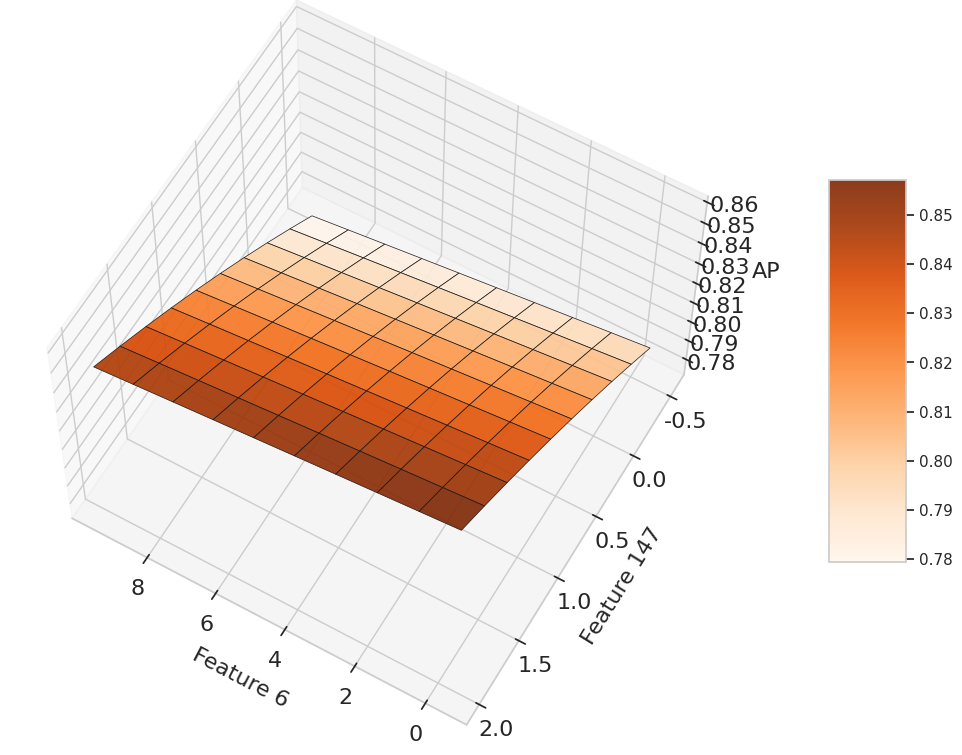

In [59]:
def partial_dependence_2d(feature_idx1, feature_idx2, feature_values1, feature_values2, formula, dataset):
    predictions = np.zeros((len(feature_values1), len(feature_values2)))
    for i, value1 in enumerate(feature_values1):
        for j, value2 in enumerate(feature_values2):
            subs_dict = {
                'x_{}'.format(k + 1): value1 if k == feature_idx1 else value2 if k == feature_idx2 else dataset['test_input'][0, k]
                for k in range(dataset['test_input'].shape[1])
            }
            predict = float(formula.subs(subs_dict))
            
            from scipy.special import expit  # expit 是 Sigmoid 函数

            # predict = float(formula.subs(subs_dict))  # 将符号表达式转换为浮点数
            predict = expit(predict) 
            predictions[i, j] = predict
    return predictions  # 选择要绘制二维部分依赖图的特征索引和范围


feature_index1 = 6  # 第一个特征索引
feature_index2 = 147  # 第二个特征索引
feature_values1 = np.linspace(min(dataset['test_input'][:, feature_index1]), max(dataset['test_input'][:, feature_index1]), num=10)
feature_values2 = np.linspace(min(dataset['test_input'][:, feature_index2]), max(dataset['test_input'][:, feature_index2]), num=10)  # 计算二维部分依赖
predictions_2d_pdp = partial_dependence_2d(feature_index1, feature_index2, feature_values1, feature_values2, formula, dataset)  # 绘制二维部分依赖图（2D PDP）
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # 创建网格
X, Y = np.meshgrid(feature_values1, feature_values2)
surf = ax.plot_surface(X, Y, predictions_2d_pdp, cmap='Oranges', edgecolor='k', linewidth=0.5, alpha=0.9)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
ax.set_xlabel('Feature {}'.format(feature_index1), fontsize=16, labelpad=10)
ax.set_ylabel('Feature {}'.format(feature_index2), fontsize=16, labelpad=10)
ax.set_zlabel('AP', fontsize=16, labelpad=10)
# ax.set_title('2D Partial Dependence Plot (PDP) for Features {} and {}'.format(feature_index1, feature_index2), fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=16)  # 设置视角  Greens
ax.view_init(elev=60, azim=120)
plt.tight_layout()
plt.grid(False)
plt.tight_layout()
plt.savefig('2D_6_147.png',dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 示例数据
x = [1, 2, 3, 4, 5]
y = [10, 15, 13, 20, 18]

# 设置画布大小
plt.figure(figsize=(8, 5))

# 绘制折线图
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Example Line')

# 添加标题和标签
plt.title("Example Line Plot")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 显示图像
plt.show()


In [ ]:
import seaborn as sns  # 定义部分依赖函数


def partial_dependence(feature_idx, feature_values, formula, dataset):
    predictions = []
    for value in feature_values:
        subs_dict = {
            'x_{}'.format(i + 1): value if i == feature_idx else dataset['test_input'][0, i]
            for i in range(dataset['test_input'].shape[1])
        }
        predict = float(formula.subs(subs_dict))
        predictions.append(predict)
    return np.array(predictions)


# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp = 0  # 假设选择第一个特征进行 PDP
feature_values_pdp = np.linspace(min(dataset['test_input'][:, feature_index_pdp]), max(dataset['test_input'][:, feature_index_pdp]), num=50)
# 计算部分依赖
predictions_pdp = partial_dependence(feature_index_pdp, feature_values_pdp, formula, dataset)
# 绘制部分依赖图（PDP）# 设置Seaborn样式
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.plot(feature_values_pdp, predictions_pdp, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)  # 添加标题和轴标签，并设置字体大小
plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Average Prediction', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
sns.despine(left=True, bottom=True)
plt.show()


In [ ]:

def partial_dependence_2d(feature_idx1, feature_idx2, feature_values1, feature_values2, formula, dataset):
    predictions = np.zeros((len(feature_values1), len(feature_values2)))
    for i, value1 in enumerate(feature_values1):
        for j, value2 in enumerate(feature_values2):
            subs_dict = {
                'x_{}'.format(k + 1): value1 if k == feature_idx1 else value2 if k == feature_idx2 else dataset['test_input'][0, k]
                for k in range(dataset['test_input'].shape[1])
            }
            predict = float(formula.subs(subs_dict))
            predictions[i, j] = predict
    return predictions  # 选择要绘制二维部分依赖图的特征索引和范围


feature_index1 = 14  # 第一个特征索引
feature_index2 = 1  # 第二个特征索引
feature_values1 = np.linspace(min(dataset['test_input'][:, feature_index1]), max(dataset['test_input'][:, feature_index1]), num=10)
feature_values2 = np.linspace(min(dataset['test_input'][:, feature_index2]), max(dataset['test_input'][:, feature_index2]), num=10)  # 计算二维部分依赖
predictions_2d_pdp = partial_dependence_2d(feature_index1, feature_index2, feature_values1, feature_values2, formula, dataset)  # 绘制二维部分依赖图（2D PDP）
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')  # 创建网格
X, Y = np.meshgrid(feature_values1, feature_values2)
surf = ax.plot_surface(X, Y, predictions_2d_pdp, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.9)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
ax.set_xlabel('Feature {}'.format(feature_index1), fontsize=14, labelpad=10)
ax.set_ylabel('Feature {}'.format(feature_index2), fontsize=14, labelpad=10)
ax.set_zlabel('Average Prediction', fontsize=14, labelpad=10)
# ax.set_title('2D Partial Dependence Plot (PDP) for Features {} and {}'.format(feature_index1, feature_index2), fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)  # 设置视角
ax.view_init(elev=60, azim=120)
plt.tight_layout()
plt.show()

In [24]:
# 1. 导入必要的库
import numpy as np
from sklearn import datasets
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


# 3. 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10],         # 较小的C值以减少模型复杂度
    'gamma': [0.001, 0.01, 0.1],     # 减少gamma范围，避免过拟合
    'epsilon': [0.01, 0.1, 0.5],     # 适当的epsilon
    'kernel': ['rbf']                # 保持rbf核函数
}

# 5. 初始化SVR模型
svr = SVR()

# 6. 使用GridSearchCV进行网格搜索
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# 7. 训练模型并搜索最优参数
grid_search.fit(X_train, y_train)

# 8. 输出最优参数组合
print(f"最优参数: {grid_search.best_params_}")

# 9. 使用最优参数进行预测
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 10. 评估模型性能
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

# 训练集指标
train_metrics = calculate_metrics(y_train, y_pred_train)
print(f"Training MSE: {train_metrics[0]:.4f}")
print(f"Training RMSE: {train_metrics[1]:.4f}")
print(f"Training MAE: {train_metrics[2]:.4f}")
print(f"Training R2: {train_metrics[4]:.4f}")
print(f"Training MAPE: {train_metrics[3]:.4f}%")


# 测试集指标
test_metrics = calculate_metrics(y_test, y_pred_test)
print(f"\nTesting MSE: {test_metrics[0]:.4f}")
print(f"Testing RMSE: {test_metrics[1]:.4f}")
print(f"Testing MAE: {test_metrics[2]:.4f}")
print(f"Testing R2: {test_metrics[4]:.4f}")
print(f"Testing MAPE: {test_metrics[3]:.4f}%")



Fitting 5 folds for each of 36 candidates, totalling 180 fits
最优参数: {'C': 10, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}
Training MSE: 0.2631
Training RMSE: 0.5130
Training MAE: 0.4294
Training R2: 0.5819
Training MAPE: inf%

Testing MSE: 0.3826
Testing RMSE: 0.6185
Testing MAE: 0.4983
Testing R2: 0.3315
Testing MAPE: inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


In [19]:
from hyperopt import hp

space = {
    # 'width': [
    #     # hp.quniform('width1', 50, 250, 1),  # 第一层宽度，范围50到250
    #     hp.quniform('width2', 2, 100, 1),   # 第二层宽度，范围2到100
    #     hp.quniform('width3', 1, 10, 1)     # 第三层宽度，范围1到10
    # ],
    'width2': hp.quniform('width2', 2, 7, 1),
    # 'width3': hp.quniform('width3', 2, 10, 1),
    # grid值可以在一个合理的范围内调整，比如1到20
    'grid': hp.quniform('grid', 15, 30, 1),
    # k的取值可以在2到20之间调整
    'k': hp.quniform('k', 2, 7, 1),
    # seed通常不需要优化，但如果需要固定，也可以保持不变
    # 'seed': 42  # 固定种子
}


def objective(params):
    from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
    def train_mse():
        from sklearn import metrics
        train_pred=model(X_train)
        # print(train_pred)
        # print(y_train)
        # y_train=y_train.detach().numpy()
        with torch.no_grad():
            train_pred=train_pred.detach().numpy()
            mse = metrics.mean_squared_error(y_train.detach().numpy(), train_pred)
            rmse = np.sqrt(mse)
            mae = metrics.mean_absolute_error(y_train.detach().numpy(), train_pred)
            r2 = metrics.r2_score(y_train.detach().numpy(), train_pred)
            def mean_absolute_percentage_error(y_true, y_pred):    
                return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            print('================(train)')
            mape = mean_absolute_percentage_error(y_train.detach().numpy(), train_pred)
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"R-squared (R2): {r2:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
        return mse
    def test_mse():
        from sklearn import metrics
        test_pred=model(X_test)
        # y_test=y_test.detach().numpy()
        with torch.no_grad():
            test_pred=test_pred.detach().numpy()
            mse = metrics.mean_squared_error(y_test.detach().numpy(), test_pred)
            rmse = np.sqrt(mse)
            mae = metrics.mean_absolute_error(y_test.detach().numpy(), test_pred)
            r2 = metrics.r2_score(y_test.detach().numpy(), test_pred)
            def mean_absolute_percentage_error(y_true, y_pred):    
                return np.mean(np.abs((y_true- y_pred) / y_true)) * 100
            print('================================================(test)')
            mape = mean_absolute_percentage_error(y_test.detach().numpy(), test_pred)
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"R-squared (R2): {r2:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
        return mse

    # 使用传入的超参数初始化 KAN 模型
    # model = KAN(width=[199,3,1], grid=int(params['grid']), k=int(params['k']), seed=params['seed'])
    model = KAN(
        width=[199, int(params['width2']), 1],  # 固定第一个和第三个参数，优化第二个参数
        grid=int(params['grid']),
        k=int(params['k']),
        # seed=params['seed']
    )
    print('----------------------------------------------')
    print("params['width2'],int(params['grid']),int(params['k'])", int(params['width2']), int(params['grid']), int(params['k']))
    # print("int(params['grid']),",int(params['grid']))
    # print("int(params['k'])",int(params['k']))
    # loss_fn=torch.nn.CrossEntropyLoss()
    # 使用指定的优化器、训练步数和评估指标训练模型
    # results = model.fit(dataset, opt="LBFGS", steps=3, metrics=(train_acc, test_acc));
    # results = model.fit(
    #     dataset,
    #     opt="LBFGS",
    #     steps=5,
    #     metrics=(train_mse, test_mse)
    #     # loss_fn=loss_fn
    # ), lamb=0.0, lamb_entropy=2.
    image_folder='video_img'
    results = model.fit(dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=15, save_fig=False, img_folder=image_folder)
    weight_train = 0.3
    weight_test = 0.7
    # accuracy_score = weight_train * results['train_acc'][-1] + weight_test * results['test_acc'][-1]
    # 
    train_mse = results['train_mse'][-1]
    test_mse = results['test_mse'][-1]
    # print('test_accuracy',test_accuracy)
    # 获取测试集准确率（results 中第二个指标是 test_acc）
    # test_accuracy = test_acc()

    # 返回负的测试集准确率，优化时最大化准确率
    return {
        'loss': -test_mse,  # 返回负的测试准确率用于最小化
        'test_mse': test_mse,  # 测试集准确率
        'train_mse': train_mse,  # 训练集准确率
        'status': 'ok'  # hyperopt 要求有 status 字段
    }  # 取负数使其最小化负准确率


from hyperopt import fmin, tpe, Trials, space_eval

# 定义 Trials 对象来跟踪训练过程
trials = Trials()

# 调用 fmin 进行优化
best = fmin(
    fn=objective,  # 目标函数
    space=space,  # 搜索空间
    algo=tpe.suggest,  # 使用TPE算法
    max_evals=5,  # 最大评估次数
    trials=trials  # 记录每次的评估
)
print('训练完毕===========================')
# 计算最佳参数
best_params = space_eval(space, best)

# 从 trials 中获取最好的评估结果
best_trial = min(trials.results, key=lambda x: x['loss'])  # 'loss' 是 objective 返回值

# 计算最佳准确率
best_mse = -best_trial['loss']  # 取反，获得准确率

print("最佳参数：", best_params)
print("最佳mse：", best_mse)

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


tensor([3.8212e-01, 5.6184e-01, 4.0315e-01, 3.2739e-01, 3.4321e-01, 4.6354e-01,
        3.7154e-01, 3.4269e-01, 5.1469e-01, 3.1828e-01, 3.8811e-01, 4.3621e-01,
        6.0325e-01, 4.1895e-01, 5.7909e-01, 2.8374e-01, 3.8569e-01, 4.6012e-01,
        4.7410e-01, 2.7811e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2695e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4321e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.6694e-01, 1.1918e-

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


Text(0, 0.5, 'feature attribution score')

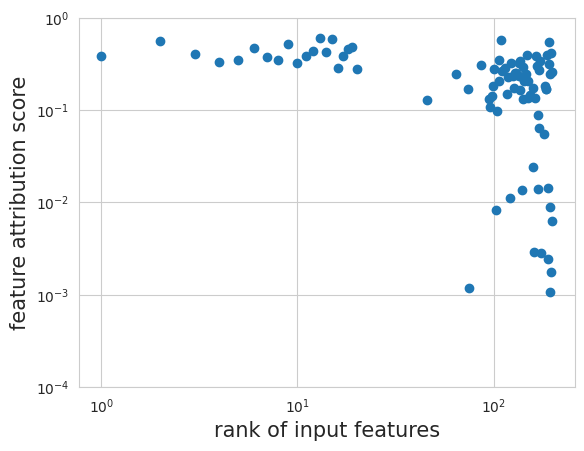

In [24]:
y_train

In [ ]:
y_test

In [ ]:
from hyperopt import hp

space = {
    # 'width': [
    #     # hp.quniform('width1', 50, 250, 1),  # 第一层宽度，范围50到250
    #     hp.quniform('width2', 2, 100, 1),   # 第二层宽度，范围2到100
    #     hp.quniform('width3', 1, 10, 1)     # 第三层宽度，范围1到10
    # ],
    'width2': hp.quniform('width2', 2, 10, 1),
    'width3': hp.quniform('width3', 2, 10, 1),
    # grid值可以在一个合理的范围内调整，比如1到20
    'grid': hp.quniform('grid', 20, 30, 1),
    # k的取值可以在2到20之间调整
    'k': hp.quniform('k', 2, 10, 1),
    # seed通常不需要优化，但如果需要固定，也可以保持不变
    # 'seed': 42  # 固定种子
}


def objective(params):
    from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
    def train_mse():
        from sklearn import metrics
        train_pred=model(X_train)
        # print(train_pred)
        # print(y_train)
        # y_train=y_train.detach().numpy()
        with torch.no_grad():
            train_pred=train_pred.detach().numpy()
            mse = metrics.mean_squared_error(y_train.detach().numpy(), train_pred)
            rmse = np.sqrt(mse)
            mae = metrics.mean_absolute_error(y_train.detach().numpy(), train_pred)
            r2 = metrics.r2_score(y_train.detach().numpy(), train_pred)
            def mean_absolute_percentage_error(y_true, y_pred):    
                return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            print('================(train)')
            mape = mean_absolute_percentage_error(y_train.detach().numpy(), train_pred)
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"R-squared (R2): {r2:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
        return mse
    def test_mse():
        from sklearn import metrics
        test_pred=model(X_test)
        # y_test=y_test.detach().numpy()
        with torch.no_grad():
            test_pred=test_pred.detach().numpy()
            mse = metrics.mean_squared_error(y_test.detach().numpy(), test_pred)
            rmse = np.sqrt(mse)
            mae = metrics.mean_absolute_error(y_test.detach().numpy(), test_pred)
            r2 = metrics.r2_score(y_test.detach().numpy(), test_pred)
            def mean_absolute_percentage_error(y_true, y_pred):    
                return np.mean(np.abs((y_true- y_pred) / y_true)) * 100
            print('======================================================(test)')
            mape = mean_absolute_percentage_error(y_test.detach().numpy(), test_pred)
            print(f"Mean Squared Error (MSE): {mse:.4f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"R-squared (R2): {r2:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
        return mse

    # 使用传入的超参数初始化 KAN 模型
    # model = KAN(width=[199,3,1], grid=int(params['grid']), k=int(params['k']), seed=params['seed'])
    model = KAN(
        width=[199, int(params['width2']), int(params['width3']), 1],  # 固定第一个和第三个参数，优化第二个参数
        grid=int(params['grid']),
        k=int(params['k']),
        # seed=params['seed']
    )
    print('----------------------------------------------')
    print("params['width2'],params['width2'],int(params['grid']),int(params['k'])", int(params['width2']), int(params['width3']), int(params['grid']), int(params['k']))
    # print("int(params['grid']),",int(params['grid']))
    # print("int(params['k'])",int(params['k']))
    # loss_fn=torch.nn.CrossEntropyLoss()
    # 使用指定的优化器、训练步数和评估指标训练模型
    # results = model.fit(dataset, opt="LBFGS", steps=3, metrics=(train_acc, test_acc));
    # results = model.fit(
    #     dataset,
    #     opt="LBFGS",
    #     steps=5,
    #     metrics=(train_mse, test_mse)
    #     # loss_fn=loss_fn
    # )
    image_folder='video_img'
    results = model.fit(dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=15, lamb=0.0, lamb_entropy=2., save_fig=False, img_folder=image_folder)
    weight_train = 0.3
    weight_test = 0.7
    # accuracy_score = weight_train * results['train_acc'][-1] + weight_test * results['test_acc'][-1]
    # 
    train_mse = results['train_mse'][-1]
    test_mse = results['test_mse'][-1]
    # print('test_accuracy',test_accuracy)
    # 获取测试集准确率（results 中第二个指标是 test_acc）
    # test_accuracy = test_acc()

    # 返回负的测试集准确率，优化时最大化准确率
    return {
        'loss': test_mse,  # 返回负的测试准确率用于最小化
        'test_mse': test_mse,  # 测试集准确率
        'train_mse': train_mse,  # 训练集准确率
        'status': 'ok'  # hyperopt 要求有 status 字段
    }  # 取负数使其最小化负准确率


from hyperopt import fmin, tpe, Trials, space_eval

# 定义 Trials 对象来跟踪训练过程
trials = Trials()

# 调用 fmin 进行优化
best = fmin(
    fn=objective,  # 目标函数
    space=space,  # 搜索空间
    algo=tpe.suggest,  # 使用TPE算法
    max_evals=10,  # 最大评估次数
    trials=trials  # 记录每次的评估
)
print('训练完毕===========================')
# 计算最佳参数
best_params = space_eval(space, best)

# 从 trials 中获取最好的评估结果
best_trial = min(trials.results, key=lambda x: x['loss'])  # 'loss' 是 objective 返回值

# 计算最佳准确率
best_mse = best_trial['loss']  

print("最佳参数：", best_params)
print("最佳mse：", best_mse)

checkpoint directory created: ./model                 
saving model version 0.0                              
----------------------------------------------        
params['width2'],params['width2'],int(params['grid']),int(params['k'])
5                                                     
8                                                     
27                                                    
9                                                     
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

description:   0%|                                                           | 0/15 [00:00<?, ?it/s]



================(train)                               
Mean Squared Error (MSE): 0.4365                      
Root Mean Squared Error (RMSE): 0.6607                
Mean Absolute Error (MAE): 0.5308                     
R-squared (R2): 0.3063                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [00:58<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4624                      
Root Mean Squared Error (RMSE): 0.6800                
Mean Absolute Error (MAE): 0.5437                     
R-squared (R2): 0.1920                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [00:58<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.61e-01 | test_loss: 6.80e-01 | reg: 0.00e+00 | :   0%|       | 0/15 [00:58<?, ?it/s]

| train_loss: 6.61e-01 | test_loss: 6.80e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:58<13:40, 58.58s/i



================(train)                               
Mean Squared Error (MSE): 0.3500                      
Root Mean Squared Error (RMSE): 0.5916                
Mean Absolute Error (MAE): 0.4675                     
R-squared (R2): 0.4438                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [01:48<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4092                      
Root Mean Squared Error (RMSE): 0.6397                
Mean Absolute Error (MAE): 0.5057                     
R-squared (R2): 0.2850                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [01:49<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.92e-01 | test_loss: 6.40e-01 | reg: 0.00e+00 | :   7%| | 1/15 [01:49<13:40, 58.58s/i

| train_loss: 5.92e-01 | test_loss: 6.40e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [01:49<11:40, 53.85s/i



================(train)                               
Mean Squared Error (MSE): 0.3019                      
Root Mean Squared Error (RMSE): 0.5495                
Mean Absolute Error (MAE): 0.4280                     
R-squared (R2): 0.5203                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [02:47<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4210                      
Root Mean Squared Error (RMSE): 0.6489                
Mean Absolute Error (MAE): 0.5111                     
R-squared (R2): 0.2643                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [02:48<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.49e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [02:48<11:40, 53.85s/i

| train_loss: 5.49e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [02:48<11:14, 56.24s/i



================(train)                               
Mean Squared Error (MSE): 0.2667                      
Root Mean Squared Error (RMSE): 0.5164                
Mean Absolute Error (MAE): 0.3963                     
R-squared (R2): 0.5763                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [03:42<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4329                      
Root Mean Squared Error (RMSE): 0.6580                
Mean Absolute Error (MAE): 0.5136                     
R-squared (R2): 0.2435                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [03:42<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.16e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [03:42<11:14, 56.24s/i

| train_loss: 5.16e-01 | test_loss: 6.58e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [03:42<10:10, 55.47s/i



================(train)                               
Mean Squared Error (MSE): 0.2408                      
Root Mean Squared Error (RMSE): 0.4907                
Mean Absolute Error (MAE): 0.3779                     
R-squared (R2): 0.6174                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [04:33<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4138                      
Root Mean Squared Error (RMSE): 0.6433                
Mean Absolute Error (MAE): 0.4980                     
R-squared (R2): 0.2769                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [04:34<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.91e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [04:34<10:10, 55.47s/i

| train_loss: 4.91e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [04:34<09:00, 54.05s/i



================(train)                               
Mean Squared Error (MSE): 0.3695                      
Root Mean Squared Error (RMSE): 0.6078                
Mean Absolute Error (MAE): 0.4834                     
R-squared (R2): 0.4129                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [05:41<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4196                      
Root Mean Squared Error (RMSE): 0.6478                
Mean Absolute Error (MAE): 0.5157                     
R-squared (R2): 0.2667                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [05:42<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.08e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [05:41<09:00, 54.05s/i

| train_loss: 6.08e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [05:41<08:48, 58.77s/i



================(train)                               
Mean Squared Error (MSE): 0.3101                      
Root Mean Squared Error (RMSE): 0.5568                
Mean Absolute Error (MAE): 0.4354                     
R-squared (R2): 0.5073                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [06:33<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4171                      
Root Mean Squared Error (RMSE): 0.6458                
Mean Absolute Error (MAE): 0.5056                     
R-squared (R2): 0.2712                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [06:33<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.57e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [06:33<08:48, 58.77s/i

| train_loss: 5.57e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [06:33<07:32, 56.53s/i



================(train)                               
Mean Squared Error (MSE): 0.2792                      
Root Mean Squared Error (RMSE): 0.5284                
Mean Absolute Error (MAE): 0.4077                     
R-squared (R2): 0.5563                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [07:32<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4079                      
Root Mean Squared Error (RMSE): 0.6386                
Mean Absolute Error (MAE): 0.4973                     
R-squared (R2): 0.2873                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [07:33<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.28e-01 | test_loss: 6.39e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [07:33<07:32, 56.53s/i

| train_loss: 5.28e-01 | test_loss: 6.39e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [07:33<06:41, 57.36s/i



================(train)                               
Mean Squared Error (MSE): 0.2550                      
Root Mean Squared Error (RMSE): 0.5049                
Mean Absolute Error (MAE): 0.3877                     
R-squared (R2): 0.5949                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [08:27<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4002                      
Root Mean Squared Error (RMSE): 0.6326                
Mean Absolute Error (MAE): 0.4883                     
R-squared (R2): 0.3008                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [08:27<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.05e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [08:27<06:41, 57.36s/i

| train_loss: 5.05e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [08:27<05:39, 56.54s/i



================(train)                               
Mean Squared Error (MSE): 0.2349                      
Root Mean Squared Error (RMSE): 0.4846                
Mean Absolute Error (MAE): 0.3714                     
R-squared (R2): 0.6268                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [09:20<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.3977                      
Root Mean Squared Error (RMSE): 0.6306                
Mean Absolute Error (MAE): 0.4835                     
R-squared (R2): 0.3051                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [09:20<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.85e-01 | test_loss: 6.31e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [09:20<05:39, 56.54s/i

| train_loss: 4.85e-01 | test_loss: 6.31e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [09:20<04:36, 55.36s/



================(train)                               
Mean Squared Error (MSE): 0.3480                      
Root Mean Squared Error (RMSE): 0.5899                
Mean Absolute Error (MAE): 0.4621                     
R-squared (R2): 0.4471                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [10:25<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4132                      
Root Mean Squared Error (RMSE): 0.6428                
Mean Absolute Error (MAE): 0.5024                     
R-squared (R2): 0.2780                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [10:26<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.90e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [10:26<04:36, 55.36s/

| train_loss: 5.90e-01 | test_loss: 6.43e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [10:26<03:54, 58.53s/



================(train)                               
Mean Squared Error (MSE): 0.2922                      
Root Mean Squared Error (RMSE): 0.5405                
Mean Absolute Error (MAE): 0.4220                     
R-squared (R2): 0.5358                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [11:18<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.4127                      
Root Mean Squared Error (RMSE): 0.6424                
Mean Absolute Error (MAE): 0.5054                     
R-squared (R2): 0.2788                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [11:18<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.41e-01 | test_loss: 6.42e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [11:18<03:54, 58.53s/

| train_loss: 5.41e-01 | test_loss: 6.42e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [11:18<02:50, 56.74s/



================(train)                               
Mean Squared Error (MSE): 0.2621                      
Root Mean Squared Error (RMSE): 0.5119                
Mean Absolute Error (MAE): 0.3986                     
R-squared (R2): 0.5836                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [12:13<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.3955                      
Root Mean Squared Error (RMSE): 0.6289                
Mean Absolute Error (MAE): 0.4875                     
R-squared (R2): 0.3089                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [12:14<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.12e-01 | test_loss: 6.29e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [12:14<02:50, 56.74s/

| train_loss: 5.12e-01 | test_loss: 6.29e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [12:14<01:52, 56.29s/



================(train)                               
Mean Squared Error (MSE): 0.2358                      
Root Mean Squared Error (RMSE): 0.4856                
Mean Absolute Error (MAE): 0.3753                     
R-squared (R2): 0.6253                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [13:07<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.3949                      
Root Mean Squared Error (RMSE): 0.6284                
Mean Absolute Error (MAE): 0.4862                     
R-squared (R2): 0.3100                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [13:07<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.86e-01 | test_loss: 6.28e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [13:07<01:52, 56.29s/

| train_loss: 4.86e-01 | test_loss: 6.28e-01 | reg: 0.00e+00 | :  93%|9| 14/15 [13:07<00:55, 55.36s/



l: 3                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 2                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 1                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 3                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 2                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 1                                                  
Length of self.edge_actscale: 3                       
Length of self.subnode_actscale: 3                    
l: 3      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)
Mean Squared Error (MSE): 0.3882                      
Root Mean Squared Error (RMSE): 0.6230                
Mean Absolute Error (MAE): 0.4826                     
R-squared (R2): 0.3217                                
Mean Absolute Percentage Error (MAPE): inf%           
  0%|          | 0/10 [14:08<?, ?trial/s, best loss=?]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.66e-01 | test_loss: 6.23e-01 | reg: 7.29e+01 | :  93%|9| 14/15 [14:08<00:55, 55.36s/

| train_loss: 4.66e-01 | test_loss: 6.23e-01 | reg: 7.29e+01 | : 100%|#| 15/15 [14:08<00:00, 57.13s/

| train_loss: 4.66e-01 | test_loss: 6.23e-01 | reg: 7.29e+01 | : 100%|#| 15/15 [14:08<00:00, 56.57s/


saving model version 0.1                              
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
----------------------------------------------                                      
params['width2'],params['width2'],int(params['grid']),int(params['k'])              
4                                                                                   
8                                                                                   
29                                                                                  
2                                                                                   
 10%|█         | 1/10 [14:09<2:07:18, 848.72s/trial, best loss: 0.38818982243537903]

description:   0%|                                                           | 0/15 [00:00<?, ?it/s]



================(train)                                                             
Mean Squared Error (MSE): 0.4795                                                    
Root Mean Squared Error (RMSE): 0.6925                                              
Mean Absolute Error (MAE): 0.5566                                                   
R-squared (R2): 0.2381                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4862                                                    
Root Mean Squared Error (RMSE): 0.6973                                              
Mean Absolute Error (MAE): 0.5636                                                   
R-squared (R2): 0.1504                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.92e-01 | test_loss: 6.97e-01 | reg: 0.00e+00 | :   0%|       | 0/15 [00:24<?, ?it/s]

| train_loss: 6.92e-01 | test_loss: 6.97e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:24<05:37, 24.12s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3605                                                    
Root Mean Squared Error (RMSE): 0.6004                                              
Mean Absolute Error (MAE): 0.4754                                                   
R-squared (R2): 0.4272                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4253                                                    
Root Mean Squared Error (RMSE): 0.6522                                              
Mean Absolute Error (MAE): 0.5122                                                   
R-squared (R2): 0.2568                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.00e-01 | test_loss: 6.52e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:48<05:37, 24.12s/i

| train_loss: 6.00e-01 | test_loss: 6.52e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [00:48<05:15, 24.26s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3133                                                    
Root Mean Squared Error (RMSE): 0.5597                                              
Mean Absolute Error (MAE): 0.4380                                                   
R-squared (R2): 0.5022                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4277                                                    
Root Mean Squared Error (RMSE): 0.6540                                              
Mean Absolute Error (MAE): 0.5125                                                   
R-squared (R2): 0.2526                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.60e-01 | test_loss: 6.54e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [01:15<05:15, 24.26s/i

| train_loss: 5.60e-01 | test_loss: 6.54e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [01:15<05:05, 25.44s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2752                                                    
Root Mean Squared Error (RMSE): 0.5246                                              
Mean Absolute Error (MAE): 0.4099                                                   
R-squared (R2): 0.5628                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 10%|█         | 1/10 [15:50<2:07:18, 848.72s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)                        
Mean Squared Error (MSE): 0.4189                                                    
Root Mean Squared Error (RMSE): 0.6472                                              
Mean Absolute Error (MAE): 0.5075                                                   
R-squared (R2): 0.2680                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 10%|█         | 1/10 [15:51<2:07:18, 848.72s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.25e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [01:42<05:05, 25.44s/i

| train_loss: 5.25e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [01:42<04:45, 25.96s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2444                                                    
Root Mean Squared Error (RMSE): 0.4944                                              
Mean Absolute Error (MAE): 0.3838                                                   
R-squared (R2): 0.6116                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4214                                                    
Root Mean Squared Error (RMSE): 0.6492                                              
Mean Absolute Error (MAE): 0.5047                                                   
R-squared (R2): 0.2636                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.94e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [02:08<04:45, 25.96s/i

| train_loss: 4.94e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [02:08<04:21, 26.19s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3554                                                    
Root Mean Squared Error (RMSE): 0.5962                                              
Mean Absolute Error (MAE): 0.4719                                                   
R-squared (R2): 0.4353                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4454                                                    
Root Mean Squared Error (RMSE): 0.6674                                              
Mean Absolute Error (MAE): 0.5259                                                   
R-squared (R2): 0.2216                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.96e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [02:37<04:21, 26.19s/i

| train_loss: 5.96e-01 | test_loss: 6.67e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [02:37<04:03, 27.02s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2832                                                    
Root Mean Squared Error (RMSE): 0.5322                                              
Mean Absolute Error (MAE): 0.4179                                                   
R-squared (R2): 0.5500                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4191                                                    
Root Mean Squared Error (RMSE): 0.6474                                              
Mean Absolute Error (MAE): 0.5083                                                   
R-squared (R2): 0.2677                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.32e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [03:01<04:03, 27.02s/i

| train_loss: 5.32e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [03:01<03:27, 25.98s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2499                                                    
Root Mean Squared Error (RMSE): 0.4999                                              
Mean Absolute Error (MAE): 0.3896                                                   
R-squared (R2): 0.6029                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4171                                                    
Root Mean Squared Error (RMSE): 0.6459                                              
Mean Absolute Error (MAE): 0.5045                                                   
R-squared (R2): 0.2711                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.00e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [03:26<03:27, 25.98s/i

| train_loss: 5.00e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [03:26<02:59, 25.67s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2260                                                    
Root Mean Squared Error (RMSE): 0.4754                                              
Mean Absolute Error (MAE): 0.3696                                                   
R-squared (R2): 0.6409                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4197                                                    
Root Mean Squared Error (RMSE): 0.6478                                              
Mean Absolute Error (MAE): 0.5008                                                   
R-squared (R2): 0.2667                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.75e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [03:50<02:59, 25.67s/i

| train_loss: 4.75e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [03:50<02:31, 25.27s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2086                                                    
Root Mean Squared Error (RMSE): 0.4567                                              
Mean Absolute Error (MAE): 0.3542                                                   
R-squared (R2): 0.6686                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4253                                                    
Root Mean Squared Error (RMSE): 0.6522                                              
Mean Absolute Error (MAE): 0.5022                                                   
R-squared (R2): 0.2568                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.57e-01 | test_loss: 6.52e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [04:14<02:31, 25.27s/i

| train_loss: 4.57e-01 | test_loss: 6.52e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [04:14<02:04, 24.97s/



================(train)                                                             
Mean Squared Error (MSE): 0.3031                                                    
Root Mean Squared Error (RMSE): 0.5505                                              
Mean Absolute Error (MAE): 0.4298                                                   
R-squared (R2): 0.5184                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4391                                                    
Root Mean Squared Error (RMSE): 0.6626                                              
Mean Absolute Error (MAE): 0.5233                                                   
R-squared (R2): 0.2327                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.51e-01 | test_loss: 6.63e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [04:43<02:04, 24.97s/

| train_loss: 5.51e-01 | test_loss: 6.63e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [04:43<01:44, 26.14s/



================(train)                                                             
Mean Squared Error (MSE): 0.2535                                                    
Root Mean Squared Error (RMSE): 0.5035                                              
Mean Absolute Error (MAE): 0.3886                                                   
R-squared (R2): 0.5972                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4237                                                    
Root Mean Squared Error (RMSE): 0.6509                                              
Mean Absolute Error (MAE): 0.5066                                                   
R-squared (R2): 0.2597                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.03e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [05:09<01:44, 26.14s/

| train_loss: 5.03e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [05:09<01:17, 25.98s/



================(train)                                                             
Mean Squared Error (MSE): 0.2276                                                    
Root Mean Squared Error (RMSE): 0.4771                                              
Mean Absolute Error (MAE): 0.3689                                                   
R-squared (R2): 0.6384                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4184                                                    
Root Mean Squared Error (RMSE): 0.6469                                              
Mean Absolute Error (MAE): 0.5010                                                   
R-squared (R2): 0.2688                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.77e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [05:35<01:17, 25.98s/

| train_loss: 4.77e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [05:35<00:52, 26.20s/



================(train)                                                             
Mean Squared Error (MSE): 0.2087                                                    
Root Mean Squared Error (RMSE): 0.4568                                              
Mean Absolute Error (MAE): 0.3511                                                   
R-squared (R2): 0.6684                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4153                                                    
Root Mean Squared Error (RMSE): 0.6444                                              
Mean Absolute Error (MAE): 0.5002                                                   
R-squared (R2): 0.2744                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.57e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [05:59<00:52, 26.20s/

| train_loss: 4.57e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  93%|9| 14/15 [05:59<00:25, 25.39s/



l: 3                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 2                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 1                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 3                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                               

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.41e-01 | test_loss: 6.45e-01 | reg: 5.32e+01 | :  93%|9| 14/15 [06:29<00:25, 25.39s/

| train_loss: 4.41e-01 | test_loss: 6.45e-01 | reg: 5.32e+01 | : 100%|#| 15/15 [06:29<00:00, 26.82s/

| train_loss: 4.41e-01 | test_loss: 6.45e-01 | reg: 5.32e+01 | : 100%|#| 15/15 [06:29<00:00, 25.97s/


saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
----------------------------------------------                                      
params['width2'],params['width2'],int(params['grid']),int(params['k'])              
8                                                                                   
6                                                                                   
26                                                                                  
4                                                                                   
 20%|██        | 2/10 [20:38<1:17:11, 578.88s/trial, best loss: 0.38818982243537903]

description:   0%|                                                           | 0/15 [00:00<?, ?it/s]



================(train)                                                             
Mean Squared Error (MSE): 0.4120                                                    
Root Mean Squared Error (RMSE): 0.6419                                              
Mean Absolute Error (MAE): 0.5123                                                   
R-squared (R2): 0.3453                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 20%|██        | 2/10 [21:19<1:17:11, 578.88s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)                        
Mean Squared Error (MSE): 0.4398                                                    
Root Mean Squared Error (RMSE): 0.6631                                              
Mean Absolute Error (MAE): 0.5290                                                   
R-squared (R2): 0.2316                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 20%|██        | 2/10 [21:20<1:17:11, 578.88s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.42e-01 | test_loss: 6.63e-01 | reg: 0.00e+00 | :   0%|       | 0/15 [00:42<?, ?it/s]

| train_loss: 6.42e-01 | test_loss: 6.63e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:42<09:48, 42.03s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3068                                                    
Root Mean Squared Error (RMSE): 0.5539                                              
Mean Absolute Error (MAE): 0.4331                                                   
R-squared (R2): 0.5125                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4191                                                    
Root Mean Squared Error (RMSE): 0.6474                                              
Mean Absolute Error (MAE): 0.5006                                                   
R-squared (R2): 0.2677                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.54e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :   7%| | 1/15 [01:07<09:48, 42.03s/i

| train_loss: 5.54e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [01:07<07:02, 32.48s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2407                                                    
Root Mean Squared Error (RMSE): 0.4906                                              
Mean Absolute Error (MAE): 0.3800                                                   
R-squared (R2): 0.6175                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4181                                                    
Root Mean Squared Error (RMSE): 0.6466                                              
Mean Absolute Error (MAE): 0.4963                                                   
R-squared (R2): 0.2693                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.91e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [01:33<07:02, 32.48s/i

| train_loss: 4.91e-01 | test_loss: 6.47e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [01:33<05:52, 29.40s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2049                                                    
Root Mean Squared Error (RMSE): 0.4527                                              
Mean Absolute Error (MAE): 0.3484                                                   
R-squared (R2): 0.6744                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4203                                                    
Root Mean Squared Error (RMSE): 0.6483                                              
Mean Absolute Error (MAE): 0.4870                                                   
R-squared (R2): 0.2655                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.53e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [02:01<05:52, 29.40s/i

| train_loss: 4.53e-01 | test_loss: 6.48e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [02:01<05:19, 29.02s/i



================(train)                                                             
Mean Squared Error (MSE): 0.1791                                                    
Root Mean Squared Error (RMSE): 0.4232                                              
Mean Absolute Error (MAE): 0.3232                                                   
R-squared (R2): 0.7154                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4279                                                    
Root Mean Squared Error (RMSE): 0.6541                                              
Mean Absolute Error (MAE): 0.4889                                                   
R-squared (R2): 0.2523                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.23e-01 | test_loss: 6.54e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [02:34<05:19, 29.02s/i

| train_loss: 4.23e-01 | test_loss: 6.54e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [02:34<05:04, 30.41s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3424                                                    
Root Mean Squared Error (RMSE): 0.5851                                              
Mean Absolute Error (MAE): 0.4625                                                   
R-squared (R2): 0.4560                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4153                                                    
Root Mean Squared Error (RMSE): 0.6445                                              
Mean Absolute Error (MAE): 0.5078                                                   
R-squared (R2): 0.2742                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.85e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [03:09<05:04, 30.41s/i

| train_loss: 5.85e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [03:09<04:47, 31.93s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2685                                                    
Root Mean Squared Error (RMSE): 0.5182                                              
Mean Absolute Error (MAE): 0.4064                                                   
R-squared (R2): 0.5733                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4003                                                    
Root Mean Squared Error (RMSE): 0.6327                                              
Mean Absolute Error (MAE): 0.4908                                                   
R-squared (R2): 0.3005                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.18e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [03:42<04:47, 31.93s/i

| train_loss: 5.18e-01 | test_loss: 6.33e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [03:42<04:18, 32.30s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2188                                                    
Root Mean Squared Error (RMSE): 0.4677                                              
Mean Absolute Error (MAE): 0.3626                                                   
R-squared (R2): 0.6524                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4149                                                    
Root Mean Squared Error (RMSE): 0.6441                                              
Mean Absolute Error (MAE): 0.4932                                                   
R-squared (R2): 0.2750                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  47%|4| 7/15 [04:15<04:18, 32.30s/i

| train_loss: 4.68e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [04:15<03:47, 32.44s/i



================(train)                                                             
Mean Squared Error (MSE): 0.1873                                                    
Root Mean Squared Error (RMSE): 0.4327                                              
Mean Absolute Error (MAE): 0.3352                                                   
R-squared (R2): 0.7024                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4210                                                    
Root Mean Squared Error (RMSE): 0.6488                                              
Mean Absolute Error (MAE): 0.4907                                                   
R-squared (R2): 0.2643                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.33e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  53%|5| 8/15 [04:44<03:47, 32.44s/i

| train_loss: 4.33e-01 | test_loss: 6.49e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [04:44<03:08, 31.43s/i



================(train)                                                             
Mean Squared Error (MSE): 0.1647                                                    
Root Mean Squared Error (RMSE): 0.4058                                              
Mean Absolute Error (MAE): 0.3109                                                   
R-squared (R2): 0.7383                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4152                                                    
Root Mean Squared Error (RMSE): 0.6444                                              
Mean Absolute Error (MAE): 0.4856                                                   
R-squared (R2): 0.2745                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.06e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  60%|6| 9/15 [05:18<03:08, 31.43s/i

| train_loss: 4.06e-01 | test_loss: 6.44e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [05:18<02:41, 32.22s/



================(train)                                                             
Mean Squared Error (MSE): 0.3179                                                    
Root Mean Squared Error (RMSE): 0.5638                                              
Mean Absolute Error (MAE): 0.4453                                                   
R-squared (R2): 0.4949                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4155                                                    
Root Mean Squared Error (RMSE): 0.6446                                              
Mean Absolute Error (MAE): 0.5034                                                   
R-squared (R2): 0.2740                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.64e-01 | test_loss: 6.45e-01 | reg: 0.00e+00 | :  67%|6| 10/15 [06:01<02:41, 32.22s/

| train_loss: 5.64e-01 | test_loss: 6.45e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [06:01<02:22, 35.53s/



================(train)                                                             
Mean Squared Error (MSE): 0.2417                                                    
Root Mean Squared Error (RMSE): 0.4917                                              
Mean Absolute Error (MAE): 0.3822                                                   
R-squared (R2): 0.6159                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.3999                                                    
Root Mean Squared Error (RMSE): 0.6323                                              
Mean Absolute Error (MAE): 0.4831                                                   
R-squared (R2): 0.3013                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.92e-01 | test_loss: 6.32e-01 | reg: 0.00e+00 | :  73%|7| 11/15 [06:30<02:22, 35.53s/

| train_loss: 4.92e-01 | test_loss: 6.32e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [06:30<01:40, 33.57s/



================(train)                                                             
Mean Squared Error (MSE): 0.1995                                                    
Root Mean Squared Error (RMSE): 0.4466                                              
Mean Absolute Error (MAE): 0.3459                                                   
R-squared (R2): 0.6830                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4092                                                    
Root Mean Squared Error (RMSE): 0.6397                                              
Mean Absolute Error (MAE): 0.4854                                                   
R-squared (R2): 0.2849                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.47e-01 | test_loss: 6.40e-01 | reg: 0.00e+00 | :  80%|8| 12/15 [07:01<01:40, 33.57s/

| train_loss: 4.47e-01 | test_loss: 6.40e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [07:01<01:05, 32.61s/



================(train)                                                             
Mean Squared Error (MSE): 0.1712                                                    
Root Mean Squared Error (RMSE): 0.4138                                              
Mean Absolute Error (MAE): 0.3182                                                   
R-squared (R2): 0.7279                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4021                                                    
Root Mean Squared Error (RMSE): 0.6341                                              
Mean Absolute Error (MAE): 0.4767                                                   
R-squared (R2): 0.2974                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 4.14e-01 | test_loss: 6.34e-01 | reg: 0.00e+00 | :  87%|8| 13/15 [07:31<01:05, 32.61s/

| train_loss: 4.14e-01 | test_loss: 6.34e-01 | reg: 0.00e+00 | :  93%|9| 14/15 [07:31<00:31, 31.92s/



l: 3                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 2                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 1                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                                                  
l: 3                                                                                
Length of self.edge_actscale: 3                                                     
Length of self.subnode_actscale: 3                               

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 3.90e-01 | test_loss: 6.32e-01 | reg: 8.00e+01 | :  93%|9| 14/15 [08:09<00:31, 31.92s/

| train_loss: 3.90e-01 | test_loss: 6.32e-01 | reg: 8.00e+01 | : 100%|#| 15/15 [08:09<00:00, 33.84s/

| train_loss: 3.90e-01 | test_loss: 6.32e-01 | reg: 8.00e+01 | : 100%|#| 15/15 [08:09<00:00, 32.66s/


saving model version 0.1                                                            
checkpoint directory created: ./model                                               
saving model version 0.0                                                            
----------------------------------------------                                      
params['width2'],params['width2'],int(params['grid']),int(params['k'])              
4                                                                                   
2                                                                                   
25                                                                                  
3                                                                                   
 30%|███       | 3/10 [28:48<1:02:48, 538.34s/trial, best loss: 0.38818982243537903]

description:   0%|                                                           | 0/15 [00:00<?, ?it/s]



================(train)                                                             
Mean Squared Error (MSE): 0.4517                                                    
Root Mean Squared Error (RMSE): 0.6721                                              
Mean Absolute Error (MAE): 0.5398                                                   
R-squared (R2): 0.2822                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4538                                                    
Root Mean Squared Error (RMSE): 0.6736                                              
Mean Absolute Error (MAE): 0.5464                                                   
R-squared (R2): 0.2071                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.72e-01 | test_loss: 6.74e-01 | reg: 0.00e+00 | :   0%|       | 0/15 [00:25<?, ?it/s]

| train_loss: 6.72e-01 | test_loss: 6.74e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:25<05:58, 25.60s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3686                                                    
Root Mean Squared Error (RMSE): 0.6071                                              
Mean Absolute Error (MAE): 0.4798                                                   
R-squared (R2): 0.4143                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4232                                                    
Root Mean Squared Error (RMSE): 0.6505                                              
Mean Absolute Error (MAE): 0.5139                                                   
R-squared (R2): 0.2605                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.07e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :   7%| | 1/15 [00:50<05:58, 25.60s/i

| train_loss: 6.07e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [00:50<05:28, 25.30s/i



================(train)                                                             
Mean Squared Error (MSE): 0.3285                                                    
Root Mean Squared Error (RMSE): 0.5732                                              
Mean Absolute Error (MAE): 0.4450                                                   
R-squared (R2): 0.4780                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4232                                                    
Root Mean Squared Error (RMSE): 0.6505                                              
Mean Absolute Error (MAE): 0.5068                                                   
R-squared (R2): 0.2605                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.73e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :  13%|1| 2/15 [01:15<05:28, 25.30s/i

| train_loss: 5.73e-01 | test_loss: 6.51e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [01:15<05:02, 25.23s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2995                                                    
Root Mean Squared Error (RMSE): 0.5472                                              
Mean Absolute Error (MAE): 0.4229                                                   
R-squared (R2): 0.5241                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 30%|███       | 3/10 [30:30<1:02:48, 538.34s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide



======================================================(test)                        
Mean Squared Error (MSE): 0.4108                                                    
Root Mean Squared Error (RMSE): 0.6409                                              
Mean Absolute Error (MAE): 0.4982                                                   
R-squared (R2): 0.2821                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
 30%|███       | 3/10 [30:31<1:02:48, 538.34s/trial, best loss: 0.38818982243537903]

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.47e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  20%|2| 3/15 [01:42<05:02, 25.23s/i

| train_loss: 5.47e-01 | test_loss: 6.41e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [01:42<04:43, 25.80s/i



================(train)                                                             
Mean Squared Error (MSE): 0.2814                                                    
Root Mean Squared Error (RMSE): 0.5304                                              
Mean Absolute Error (MAE): 0.4063                                                   
R-squared (R2): 0.5529                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4170                                                    
Root Mean Squared Error (RMSE): 0.6458                                              
Mean Absolute Error (MAE): 0.5026                                                   
R-squared (R2): 0.2713                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 5.30e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  27%|2| 4/15 [02:08<04:43, 25.80s/i

| train_loss: 5.30e-01 | test_loss: 6.46e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [02:08<04:18, 25.88s/i



================(train)                                                             
Mean Squared Error (MSE): 0.4229                                                    
Root Mean Squared Error (RMSE): 0.6503                                              
Mean Absolute Error (MAE): 0.5160                                                   
R-squared (R2): 0.3280                                                              
Mean Absolute Percentage Error (MAPE): inf%                                         
======================================================(test)                        
Mean Squared Error (MSE): 0.4431                                                    
Root Mean Squared Error (RMSE): 0.6657                                              
Mean Absolute Error (MAE): 0.5286                                                   
R-squared (R2): 0.2257                                                              
Mean Absolute Percentage Error (MAPE): inf%                      

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide

/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide

| train_loss: 6.50e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  33%|3| 5/15 [02:35<04:18, 25.88s/i

| train_loss: 6.50e-01 | test_loss: 6.66e-01 | reg: 0.00e+00 | :  40%|4| 6/15 [02:35<03:54, 26.09s/i



In [11]:
model.feature_score

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3555, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3352, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1877,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.6158, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.4470, 0.1678, 0.0000, 0.6072, 0.3413, 0.0000, 0.3287,
        0.0000, 0.0416, 0.1869, 0.0372, 0.1075, 0.2751, 0.0000, 0.6635, 0.3023,
        0.0000, 0.0000, 0.0000, 0.2546, 0.0000, 0.0000, 0.1896, 0.3002, 0.0000,
        0.0000, 0.0715, 0.2335, 0.0000, 0.0000, 0.0000, 0.2570, 0.2458, 0.0000,
        0.1467, 0.5692, 0.0000, 0.0000, 

l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


Text(0, 0.5, 'feature attribution score')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


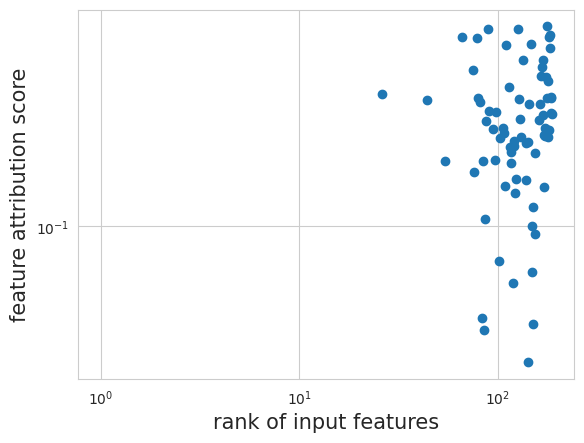

In [16]:
# input_vars = [r'$x_{'+str(i)+'}$' for i in range(n_var)]
n_var=187
plt.scatter(np.arange(n_var)+1, model.feature_score.cpu().detach().numpy())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [21]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.datasets import make_regression
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlp = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# 预测
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

# 计算评估指标
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

# 训练集指标
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training MSE: {train_metrics[0]:.4f}")
print(f"Training RMSE: {train_metrics[1]:.4f}")
print(f"Training MAE: {train_metrics[2]:.4f}")
print(f"Training MAPE: {train_metrics[3]:.4f}%")
print(f"Training R2: {train_metrics[4]:.4f}")

# 测试集指标
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"\nTesting MSE: {test_metrics[0]:.4f}")
print(f"Testing RMSE: {test_metrics[1]:.4f}")
print(f"Testing MAE: {test_metrics[2]:.4f}")
print(f"Testing MAPE: {test_metrics[3]:.4f}%")
print(f"Testing R2: {test_metrics[4]:.4f}")


Training MSE: 0.2534
Training RMSE: 0.5034
Training MAE: 0.3968
Training MAPE: inf%
Training R2: 0.5973

Testing MSE: 0.4030
Testing RMSE: 0.6348
Testing MAE: 0.4960
Testing MAPE: inf%
Testing R2: 0.2957


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


l: 2
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2
l: 1
Length of self.edge_actscale: 2
Length of self.subnode_actscale: 2


Text(0, 0.5, 'feature attribution score')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


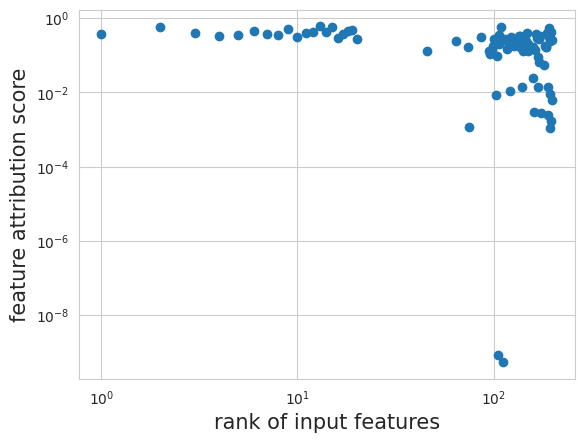

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 生成模拟数据（你可以替换为自己的数据）
np.random.seed(42)
# X = np.random.rand(100, 5)
# y = np.random.rand(100)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数网格
param_grid = {
    'hidden_layer_sizes': [(30,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# 构建MLP模型
mlp = MLPRegressor(max_iter=1000, random_state=42)

# 使用网格搜索进行超参数优化
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳模型进行预测
best_mlp = grid_search.best_estimator_

y_train_pred = best_mlp.predict(X_train)
y_test_pred = best_mlp.predict(X_test)

# 计算评估指标
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

# 训练集指标
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training MSE: {train_metrics[0]:.4f}")
print(f"Training RMSE: {train_metrics[1]:.4f}")
print(f"Training MAE: {train_metrics[2]:.4f}")
print(f"Training MAPE: {train_metrics[3]:.4f}%")
print(f"Training R2: {train_metrics[4]:.4f}")

# 测试集指标
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"\nTesting MSE: {test_metrics[0]:.4f}")
print(f"Testing RMSE: {test_metrics[1]:.4f}")
print(f"Testing MAE: {test_metrics[2]:.4f}")
print(f"Testing MAPE: {test_metrics[3]:.4f}%")
print(f"Testing R2: {test_metrics[4]:.4f}")


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 生成模拟数据（你可以替换为自己的数据）
np.random.seed(42)
# X = np.random.rand(100, 5)
# y = np.random.rand(100)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数网格
param_grid = {
    'hidden_layer_sizes': [(10,10),(20,20),(30,30), (40,40), (50,50), (60,60), (70,70), (80,80),(90,90),(50,100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# 构建MLP模型
mlp = MLPRegressor(max_iter=1000, random_state=42)

# 使用网格搜索进行超参数优化
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳模型进行预测
best_mlp = grid_search.best_estimator_

y_train_pred = best_mlp.predict(X_train)
y_test_pred = best_mlp.predict(X_test)

# 计算评估指标
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, mape, r2

# 训练集指标
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training MSE: {train_metrics[0]:.4f}")
print(f"Training RMSE: {train_metrics[1]:.4f}")
print(f"Training MAE: {train_metrics[2]:.4f}")
print(f"Training MAPE: {train_metrics[3]:.4f}%")
print(f"Training R2: {train_metrics[4]:.4f}")

# 测试集指标
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"\nTesting MSE: {test_metrics[0]:.4f}")
print(f"Testing RMSE: {test_metrics[1]:.4f}")
print(f"Testing MAE: {test_metrics[2]:.4f}")
print(f"Testing MAPE: {test_metrics[3]:.4f}%")
print(f"Testing R2: {test_metrics[4]:.4f}")


Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 80), 'learning_rate': 'constant', 'solver': 'adam'}
Training MSE: 0.2138
Training RMSE: 0.4624
Training MAE: 0.3534
Training MAPE: inf%
Training R2: 0.6602

Testing MSE: 0.3646
Testing RMSE: 0.6038
Testing MAE: 0.4688
Testing MAPE: inf%
Testing R2: 0.3628


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide


In [18]:
from hyperopt import hp
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import fmin, tpe, hp, Trials, space_eval

space = {
    # 'width': [
    #     # hp.quniform('width1', 50, 250, 1),  # 第一层宽度，范围50到250
    #     hp.quniform('width2', 2, 100, 1),   # 第二层宽度，范围2到100
    #     hp.quniform('width3', 1, 10, 1)     # 第三层宽度，范围1到10
    # ],
    'hidden_layer_sizes1': hp.quniform('hidden_layer_sizes1', 30, 100, 10),
    'hidden_layer_sizes2': hp.quniform('hidden_layer_sizes2', 30, 100, 10),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'solver': hp.choice('solver', ['adam', 'sgd']),
    # 'alpha': hp.loguniform('alpha', np.log(1e-6), np.log(1e-2)),
    # 'learning_rate_init': hp.loguniform('learning_rate_init', np.log(1e-4), np.log(1e-1)),
    'batch_size': hp.quniform('batch_size', 16, 128, 16)
}


def objective(params):
    params['batch_size'] = int(params['batch_size'])
    
    # 创建 MLP 回归器，使用传递的参数
    mlp = MLPRegressor(hidden_layer_sizes=(int(params['hidden_layer_sizes1']),int(params['hidden_layer_sizes2'])), 
                       activation=params['activation'],solver=params['solver'],
                       # alpha=params['alpha'],learning_rate=params['learning_rate_init'],
                       batch_size=int(params['batch_size']),
                       max_iter=1000, random_state=42 )
    
    # 拟合训练数据
    mlp.fit(X_train, y_train)
    
    # 预测测试集
    y_pred = mlp.predict(X_test)
    
    # 计算均方误差，作为优化的目标
    mse = mean_squared_error(y_test, y_pred)

    # 返回负的测试集准确率，优化时最大化准确率
    return {'loss': mse}

from hyperopt import fmin, tpe, Trials, space_eval

# 定义 Trials 对象来跟踪训练过程
trials = Trials()

# 调用 fmin 进行优化
best = fmin(
    fn=objective,  # 目标函数
    space=space,  # 搜索空间
    algo=tpe.suggest,  # 使用TPE算法
    max_evals=5,  # 最大评估次数
    trials=trials  # 记录每次的评估
)
print('训练完毕===========================')
# 计算最佳参数
best_params = space_eval(space, best)

# 从 trials 中获取最好的评估结果
best_trial = min(trials.results, key=lambda x: x['loss'])  # 'loss' 是 objective 返回值

# 计算最佳准确率
best_mse = -best_trial['loss']  # 取反，获得准确率

print("最佳参数：", best_params)
print("最佳mse：", best_mse)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

job exception: 'status'



  0%|          | 0/5 [00:35<?, ?trial/s, best loss=?]


KeyError: 'status'

In [ ]:
from hyperopt import hp

space = {
    # 'width': [
    #     # hp.quniform('width1', 50, 250, 1),  # 第一层宽度，范围50到250
    #     hp.quniform('width2', 2, 100, 1),   # 第二层宽度，范围2到100
    #     hp.quniform('width3', 1, 10, 1)     # 第三层宽度，范围1到10
    # ],
    'width2': hp.quniform('width2', 2, 7, 1),
    'width3': hp.quniform('width3', 2, 7, 1),
    # grid值可以在一个合理的范围内调整，比如1到20
    'grid': hp.quniform('grid', 2, 7, 1),
    # k的取值可以在2到20之间调整
    'k': hp.quniform('k', 2, 7, 1),
    # seed通常不需要优化，但如果需要固定，也可以保持不变
    # 'seed': 42  # 固定种子
}


In [ ]:

def objective(params):
    from sklearn.metrics import roc_auc_score, confusion_matrix, matthews_corrcoef
    def train_acc():
        pred = model(X_train)
        with torch.no_grad():
            pred_labels = (pred > 0.5).float()
            auc = roc_auc_score(y_train.cpu(), pred.cpu())

            # 混淆矩阵计算
            tn, fp, fn, tp = confusion_matrix(y_train.cpu(), pred_labels.cpu()).ravel()

            # Specificity (SP)
            sp = tn / (tn + fp) if (tn + fp) > 0 else 0

            acc = (tp + tn) / (tp + tn + fp + fn)

            # Sensitivity (SN)
            sn = tp / (tp + fn) if (tp + fn) > 0 else 0

            # Matthews Correlation Coefficient (MCC)
            mcc = matthews_corrcoef(y_train.cpu(), pred_labels.cpu())
        print(f"ACC: {acc:.4f}, AUC: {auc:.4f}, SP: {sp:.4f}, MCC: {mcc:.4f}, SN: {sn:.4f}")
        return torch.mean((torch.round(model(X_train)[:, 0]) == y_train[:, 0]).float())

    def test_acc():
        pred = model(X_test)
        with torch.no_grad():
            pred_labels = (pred > 0.5).float()
            auc = roc_auc_score(y_test.cpu(), pred.cpu())

            # 混淆矩阵计算
            tn, fp, fn, tp = confusion_matrix(y_test.cpu(), pred_labels.cpu()).ravel()

            # Specificity (SP)
            sp = tn / (tn + fp) if (tn + fp) > 0 else 0

            acc = (tp + tn) / (tp + tn + fp + fn)

            # Sensitivity (SN)
            sn = tp / (tp + fn) if (tp + fn) > 0 else 0

            # Matthews Correlation Coefficient (MCC)
            mcc = matthews_corrcoef(y_test.cpu(), pred_labels.cpu())
        print(f"ACC: {acc:.4f}, AUC(test): {auc:.4f}, SP: {sp:.4f}, MCC: {mcc:.4f}, SN: {sn:.4f}")
        return torch.mean((torch.round(model(X_test)[:, 0]) == y_test[:, 0]).float())

    # 使用传入的超参数初始化 KAN 模型
    # model = KAN(width=[199,3,1], grid=int(params['grid']), k=int(params['k']), seed=params['seed'])
    model = KAN(
        width=[199, int(params['width2']), int(params['width3']), 1],  # 固定第一个和第三个参数，优化第二个参数
        grid=int(params['grid']),
        k=int(params['k']),
        # seed=params['seed']
    )
    print("params['width2'],params['width2'],int(params['grid']),int(params['k'])", int(params['width2']), int(params['width3']), int(params['grid']), int(params['k']))
    # print("int(params['grid']),",int(params['grid']))
    # print("int(params['k'])",int(params['k']))
    # loss_fn=torch.nn.CrossEntropyLoss()
    # 使用指定的优化器、训练步数和评估指标训练模型
    # results = model.fit(dataset, opt="LBFGS", steps=3, metrics=(train_acc, test_acc));
    results = model.fit(
        dataset,
        opt="LBFGS",
        steps=5,
        metrics=(train_acc, test_acc)
        # loss_fn=loss_fn
    )
    weight_train = 0.3
    weight_test = 0.7
    # accuracy_score = weight_train * results['train_acc'][-1] + weight_test * results['test_acc'][-1]
    # 
    train_accuracy = results['train_acc'][-1]
    test_accuracy = results['test_acc'][-1]
    # print('test_accuracy',test_accuracy)
    # 获取测试集准确率（results 中第二个指标是 test_acc）
    # test_accuracy = test_acc()

    # 返回负的测试集准确率，优化时最大化准确率
    return {
        'loss': -test_accuracy,  # 返回负的测试准确率用于最小化
        'test_acc': test_accuracy,  # 测试集准确率
        'train_acc': train_accuracy,  # 训练集准确率
        'status': 'ok'  # hyperopt 要求有 status 字段
    }  # 取负数使其最小化负准确率


In [ ]:

from hyperopt import fmin, tpe, Trials, space_eval

# 定义 Trials 对象来跟踪训练过程
trials = Trials()

# 调用 fmin 进行优化
best = fmin(
    fn=objective,  # 目标函数
    space=space,  # 搜索空间
    algo=tpe.suggest,  # 使用TPE算法
    max_evals=20,  # 最大评估次数
    trials=trials  # 记录每次的评估
)

# 计算最佳参数
best_params = space_eval(space, best)

# 从 trials 中获取最好的评估结果
best_trial = min(trials.results, key=lambda x: x['loss'])  # 'loss' 是 objective 返回值

# 计算最佳准确率
best_accuracy = -best_trial['loss']  # 取反，获得准确率

print("最佳参数：", best_params)
print("最佳准确率：", best_accuracy)

In [10]:
# model.fit(dataset, opt="LBFGS", steps=20)
# image_folder='./regression' fold_image save_fig
model.fit(dataset, opt="LBFGS", steps=5)
# model.plot(beta=100)

| train_loss: 7.93e-01 | test_loss: 7.57e-01 | reg: 0.00e+00 | :   0%|        | 0/5 [01:37<?, ?it/s]

cannot plot since data2 are not saved. Set save_act=True first.
l: 2
Length of self.edge_actscale: 0
Length of self.subnode_actscale: 0


IndexError: list index out of range

In [13]:
lib = ['x','x^2','x^3','x^4','x^5','x^6','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
formula

checkpoint directory created: ./model
saving model version 0.0


tensor([[0.4036],
        [0.3279],
        [0.3422],
        ...,
        [0.4994],
        [0.3475],
        [0.3370]], grad_fn=<AddBackward0>)

In [70]:
prediction = []
def acc(formula, X):    
    batch = X.shape[0]  # 获取批量大小    
    for i in range(batch):
        subs_dict = {}
        n=len(X[0])
# 假设 X 的形状是 (n_samples, 150)
        for j in range(1, 187):
            subs_dict[f'x_{j}'] = X[i, j-1]  # j-1 因为 Python 的索引从 0 开始
        # subs_dict = {            
        #     'x_1': X[i, 0],            
        #     'x_2': X[i, 1],            
        #     'x_3': X[i, 2],            
        #     'x_4': X[i, 3],            
        #     'x_5': X[i, 4],            
        #     'x_6': X[i, 5],            
        #     'x_7': X[i, 6],            
        #     'x_8': X[i, 7],
        #     'x_9': X[i, 8],            
        #     'x_10': X[i, 9],            
        #     'x_11': X[i, 10],            
        #     'x_12': X[i, 11],            
        #     'x_13': X[i, 12],            
        #     'x_14': X[i, 13],            
        #     'x_15': X[i, 14],            
        #     'x_16': X[i, 15],
        #     'x_17': X[i, 16],            
        #     'x_18': X[i, 17],            
        #     'x_19': X[i, 18],            
        #     'x_20': X[i, 19],     
        # }        # 使用给定的公式对当前样本进行预测，并将结果转换为浮点数        
        predict = float(formula.subs(subs_dict))       
        prediction.append(predict)  # 将预测结果添加到列表中       
    return prediction
test_pred = acc(formula, dataset['test_input'])
# y_test_h = y_test*y_std+y_mean
# pred_test_h = np.array(test_pred)*y_std+y_mean
import seaborn as sns
colors = sns.color_palette("husl", 3)
plt.figure(figsize=(15,5),dpi=300)
# plt.scatter(y_test_h, pred_test_h, label='测试集', alpha=0.3, color=colors[2])
plt.scatter(y_test, test_pred, label='测试集', alpha=0.3, color=colors[2])
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.legend()
plt.tight_layout()
plt.show()

TypeError: Cannot convert expression to float

In [14]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test, test_pred)
r2 = metrics.r2_score(y_test, test_pred)
def mean_absolute_percentage_error(y_true, y_pred):    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, test_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

| train_loss: 7.93e-01 | test_loss: 7.57e-01 | reg: 1.46e+01 | : 100%|█| 20/20 [04:54<00:00, 14.74s/

saving model version 0.1


{'train_loss': [array(0.793319, dtype=float32),
  array(0.7933088, dtype=float32),
  array(0.79330814, dtype=float32),
  array(0.7933079, dtype=float32),
  array(0.7933078, dtype=float32),
  array(0.7941434, dtype=float32),
  array(0.79331714, dtype=float32),
  array(0.7933087, dtype=float32),
  array(0.7933087, dtype=float32),
  array(0.79330814, dtype=float32),
  array(0.80825907, dtype=float32),
  array(0.7933182, dtype=float32),
  array(0.79330814, dtype=float32),
  array(0.79330796, dtype=float32),
  array(0.79330766, dtype=float32),
  array(0.7939734, dtype=float32),
  array(0.7933128, dtype=float32),
  array(0.7933083, dtype=float32),
  array(0.7933081, dtype=float32),
  array(0.7933079, dtype=float32)],
 'test_loss': [array(0.75726235, dtype=float32),
  array(0.75727475, dtype=float32),
  array(0.75727314, dtype=float32),
  array(0.75727355, dtype=float32),
  array(0.7572745, dtype=float32),
  array(0.7585074, dtype=float32),
  array(0.7572909, dtype=float32),
  array(0.7572793

In [15]:
from sklearn import metrics
mse = metrics.mean_squared_error(y_test_h, pred_test_h)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test_h, pred_test_h)
r2 = metrics.r2_score(y_test_h, pred_test_h)
def mean_absolute_percentage_error(y_true, y_pred):    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_h, pred_test_h)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

fixing (0,0,0) with x, r2=0.0, c=1
fixing (0,0,1) with x, r2=0.0, c=1
fixing (0,0,2) with x, r2=0.0, c=1
fixing (0,0,3) with x, r2=0.0, c=1
fixing (0,0,4) with x, r2=0.0, c=1
fixing (0,1,0) with x, r2=0.0, c=1
fixing (0,1,1) with x, r2=0.0, c=1
fixing (0,1,2) with x, r2=0.0, c=1
fixing (0,1,3) with x, r2=0.0, c=1
fixing (0,1,4) with x, r2=0.0, c=1
fixing (0,2,0) with x, r2=0.0, c=1
fixing (0,2,1) with x, r2=0.0, c=1
fixing (0,2,2) with x, r2=0.0, c=1
fixing (0,2,3) with x, r2=0.0, c=1
fixing (0,2,4) with x, r2=0.0, c=1
fixing (0,3,0) with x, r2=0.0, c=1
fixing (0,3,1) with x, r2=0.0, c=1
fixing (0,3,2) with x, r2=0.0, c=1
fixing (0,3,3) with x, r2=0.0, c=1
fixing (0,3,4) with x, r2=0.0, c=1
fixing (0,4,0) with x, r2=0.0, c=1
fixing (0,4,1) with x, r2=0.0, c=1
fixing (0,4,2) with x, r2=0.0, c=1
fixing (0,4,3) with x, r2=0.0, c=1
fixing (0,4,4) with x, r2=0.0, c=1
fixing (0,5,0) with x, r2=0.0, c=1
fixing (0,5,1) with x, r2=0.0, c=1
fixing (0,5,2) with x, r2=0.0, c=1
fixing (0,5,3) with 

0.00032189999154291*x_101 + 5.43962994710832e-5*x_102 + 0.000159645022713953*x_105 - 1.21701793635423e-5*x_106 - 6.52105032420902e-5*x_107 - 0.000112712601810879*x_109 + 0.00020342627154401*x_110 - 0.000163441754325646*x_111 - 5.54752088260883e-5*x_112 - 0.000140605697272507*x_114 - 1.70487912732293e-5*x_115 - 8.57555930243232e-5*x_116 - 0.000255311478529058*x_117 - 0.000627031211548729*x_118 + 3.06701279647234e-6*x_119 + 0.000934812522636505*x_120 - 9.91493533876576e-5*x_121 - 9.11155061932385e-5*x_122 + 0.000278224375532405*x_123 + 0.000111974813922511*x_124 + 2.24740434999717e-5*x_126 - 8.37812470886311e-5*x_128 + 7.3094692320139e-6*x_129 - 4.3645714406206e-5*x_130 - 0.000352700396471797*x_132 - 0.000153017056671355*x_133 + 9.87075767288683e-5*x_137 - 0.000327739159366043*x_138 - 6.7584132664048e-5*x_139 - 0.000143586231147654*x_140 - 0.000173138729334469*x_141 + 0.000114175013367094*x_142 - 0.000457135705603516*x_143 - 1.09597100030347e-5*x_144 + 0.000124007771809452*x_146 + 0.0004

In [16]:
print(X_train[0],y_test[0])

torch.Size([1217, 199])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Glyph 27979 (\N{CJK UNIF

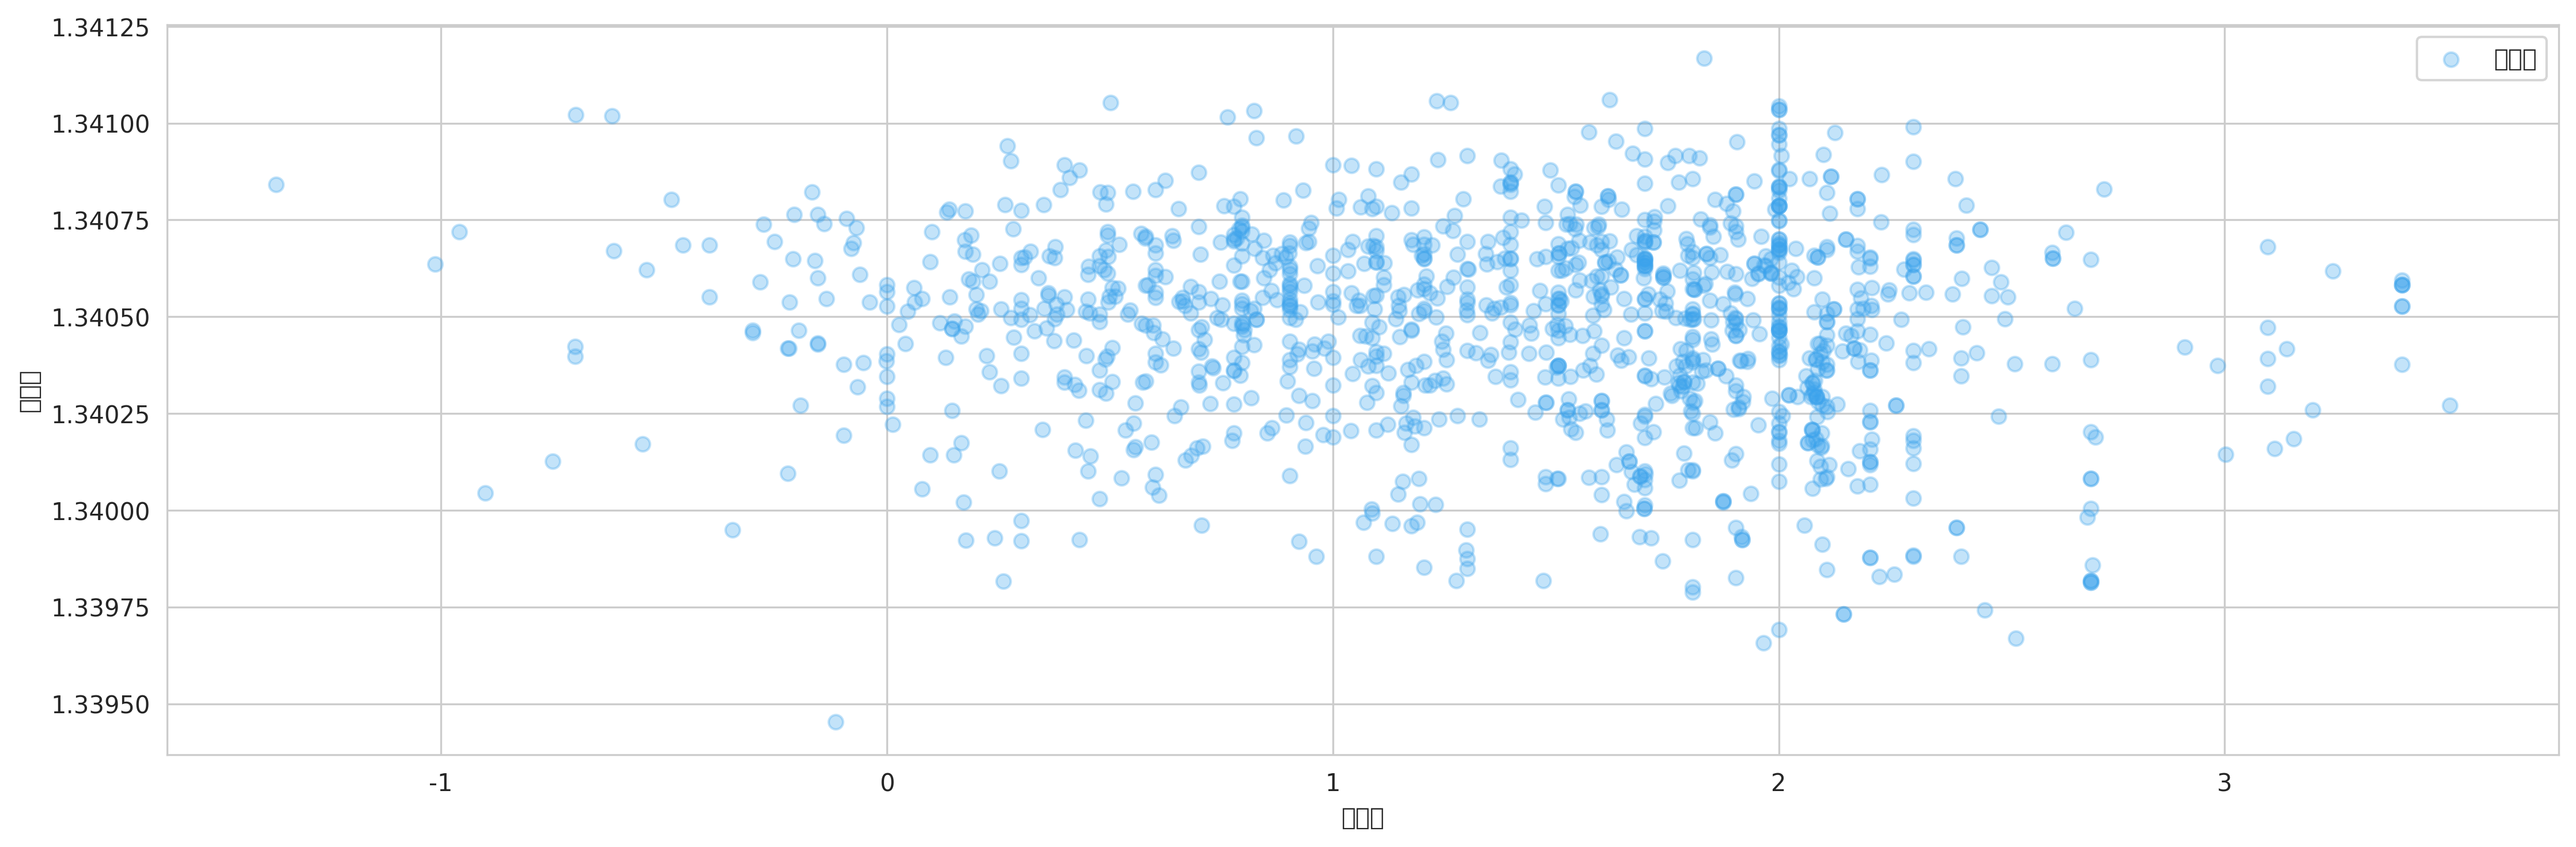

In [17]:
import numpy as np # 假设 predict 是您的预测分数数组
if  np.isnan(y).any() or np.isinf(y).any() : 
   print("数组中含有 NaN 或无穷大的值")


In [11]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# 创建 MLPRegressor 模型
mlp = MLPRegressor(max_iter=100, random_state=42)

# 创建 GridSearchCV 对象
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# 训练模型
grid_search.fit(X_train, y_train)

# 查看最佳参数组合
print("Best parameters found: ", grid_search.best_params_)

# 使用最佳模型进行预测
y_pred = grid_search.predict(X_test)
print(y_pred,y_train)
# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE计算

# 输出评估指标
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet

Best parameters found:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
[1.52385257 0.92454369 1.284129   ... 3.08676691 1.31151541 0.54374201] [-0.98944236  2.          0.78701563 ...  1.15514723  2.27004404
  2.        ]
Mean Squared Error (MSE): 0.3924
Root Mean Squared Error (RMSE): 0.6264
Mean Absolute Error (MAE): 0.4999
R-squared (R2): 0.3144
Mean Absolute Percentage Error (MAPE): inf%


/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/wangli/anaconda3/envs/mykan/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


In [23]:
import seaborn as sns# 定义部分依赖函数
def partial_dependence(feature_idx, feature_values, formula, dataset):    
    predictions = []    
    for value in feature_values:        
        subs_dict = {            
            'x_{}'.format(i+1): value if i == feature_idx else dataset['test_input'][0, i]            
            for i in range(dataset['test_input'].shape[1])        
        }        
        predict = float(formula.subs(subs_dict))        
        predictions.append(predict)    
    return np.array(predictions)
    
# dataset 是你的数据集，formula 是你的模型公式
# 选择要绘制部分依赖图的特征索引和范围
feature_index_pdp = 0  # 假设选择第一个特征进行 PDP
feature_values_pdp = np.linspace(min(dataset['test_input'][:, feature_index_pdp]), max(dataset['test_input'][:, feature_index_pdp]), num=50)
# 计算部分依赖
predictions_pdp = partial_dependence(feature_index_pdp, feature_values_pdp, formula, dataset)
# 绘制部分依赖图（PDP）# 设置Seaborn样式
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
plt.plot(feature_values_pdp, predictions_pdp, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)# 添加标题和轴标签，并设置字体大小
plt.title('Partial Dependence Plot (PDP) for Feature {}'.format(feature_index_pdp), fontsize=16)
plt.xlabel('Feature Value', fontsize=14)
plt.ylabel('Average Prediction', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
# 添加背景和框架
sns.despine(left=True, bottom=True)
plt.show()

SyntaxError: invalid syntax (790178547.py, line 30)

In [ ]:
def ice(feature_idx, feature_values, formula, dataset):    
    ice_predictions = []    
    for i in range(dataset['test_input'].shape[0]):        
        individual_predictions = []        
        for value in feature_values:            
            subs_dict = {                
                'x_{}'.format(j+1): value if j == feature_idx else dataset['test_input'][i, j]                
                for j in range(dataset['test_input'].shape[1])            
            }            
            predict = float(formula.subs(subs_dict))            
            individual_predictions.append(predict)        
            ice_predictions.append(individual_predictions)    
    return np.array(ice_predictions)
# 选择要绘制个体条件期望（ICE）的特征索引和范围
feature_index_ice = 0  # 假设选择第一个特征进行 ICE
feature_values_ice = np.linspace(min(dataset['test_input'][:, feature_index_ice]), max(dataset['test_input'][:, feature_index_ice]), num=10)

# 计算个体条件期望（ICE）
ice_predictions = ice(feature_index_ice, feature_values_ice, formula, dataset)
# 绘制个体条件期望（ICE）图
# 
plt.figure(figsize=(15, 5))
for i in range(len(ice_predictions)):    
    plt.plot(feature_values_ice, ice_predictions[i], color='grey', alpha=0.2)
    plt.xlabel('Feature Value')
    plt.ylabel('Prediction')
    plt.title('Individual Conditional Expectation (ICE) Plot for Feature {}'.format(feature_index_ice))
    plt.grid(True)
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D# 定义二维部分依赖函数
def partial_dependence_2d(feature_idx1, feature_idx2, feature_values1, feature_values2, formula, dataset):    
    predictions = np.zeros((len(feature_values1), len(feature_values2)))    
    for i, value1 in enumerate(feature_values1):        
        for j, value2 in enumerate(feature_values2):            
            subs_dict = {                
                'x_{}'.format(k+1): value1 if k == feature_idx1 else value2 if k == feature_idx2 else dataset['test_input'][0, k]                
                for k in range(dataset['test_input'].shape[1])            
            }            
            predict = float(formula.subs(subs_dict))            
            predictions[i, j] = predict    
    return predictions# 选择要绘制二维部分依赖图的特征索引和范围
feature_index1 = 0  # 第一个特征索引
feature_index2 = 1  # 第二个特征索引
feature_values1 = np.linspace(min(dataset['test_input'][:, feature_index1]), max(dataset['test_input'][:, feature_index1]), num=10)
feature_values2 = np.linspace(min(dataset['test_input'][:, feature_index2]), max(dataset['test_input'][:, feature_index2]), num=10)# 计算二维部分依赖
predictions_2d_pdp = partial_dependence_2d(feature_index1, feature_index2, feature_values1, feature_values2, formula, dataset)# 绘制二维部分依赖图（2D PDP）
sns.set(style="whitegrid")
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')# 创建网格
X, Y = np.meshgrid(feature_values1, feature_values2)
surf = ax.plot_surface(X, Y, predictions_2d_pdp, cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.9)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, pad=0.1)
ax.set_xlabel('Feature {}'.format(feature_index1), fontsize=14, labelpad=10)
ax.set_ylabel('Feature {}'.format(feature_index2), fontsize=14, labelpad=10)
ax.set_zlabel('Average Prediction', fontsize=14, labelpad=10)
ax.set_title('2D Partial Dependence Plot (PDP) for Features {} and {}'.format(feature_index1, feature_index2), fontsize=16, pad=20)
ax.tick_params(axis='both', which='major', labelsize=12)# 设置视角
ax.view_init(elev=60, azim=120)
plt.tight_layout()
plt.show()